# Movie Creation Analysis

Authors: Matt Silver, Brian Woo

## Overview

This project involves data cleaning, imputations, analysis, and visualizations to generate insights for a business stakeholder. The goal is to determine the most successful film genres currently dominating the box office, providing actionable insights for your company's new movie studio.

## Business Problem

### A leap into films
**Goal:**
- Our client is looking at an opportunity to diversify their business by exploring the film industry. In particular they are interested in creating original video content. They have created a new movie studio, but they don't know anything about creating movies. Our jobs as data scientists is to dive deep into the types of films that are currently doing the best at the box office, and take those findings and translating them into actionable insights that the CEO of our company could use to help determine which types of films are the most beneficial to create.

**Priorities:**
1. Ratings
    - The best rated films are usually the best films out there
2. Box Office Performance
    - Analyze the total grosses for each category
3. Profits
    - Compare the gross and the production budget to find out how much each of the film would profit
4. Year of Release
    - Determine if the a specific type of genre is increasing in popularity
5. Production Studios
    - Filter out the best production studios to pair with so they can find all of the proper casting and team for the film
6. Sequels
    - Determine if films that have sequels are doing well

### Souces of Data

- Box Office Mojo
- IMDB
- TheMovieDB
- The Numbers

## Extracting datasets

In [5415]:
# imports for extracting data
import os
import gzip
import shutil
import zipfile

# imports for data manipulation
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats as stats

# import for data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [5147]:
# extracting gz file to a folder called extractedData
source_directory = 'zippedData'
destination_directory = 'extractedData'

# Ensure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)

# List all .gz files in the source directory
gz_files = [f for f in os.listdir(source_directory) if f.endswith('.gz')]

# Loop through each .gz file and extract it
for gz_file in gz_files:
    gz_file_path = os.path.join(source_directory, gz_file)
    decompressed_file_path = os.path.join(destination_directory, os.path.splitext(gz_file)[0])

    # Open the .gz file and write the decompressed data to the destination directory
    with gzip.open(gz_file_path, 'rb') as f_in:
        with open(decompressed_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [5148]:
# extracting the zip file to a folder called extractedData
extract_to_directory = 'extractedData'  

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to_directory, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile('zippedData/im.db.zip'  , 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

## Understanding the Data

In [5149]:
# reading the csv files into dataframes
box_office_mojo_df = pd.read_csv('extractedData/bom.movie_gross.csv')
movie_db_df = pd.read_csv('extractedData/tmdb.movies.csv')
numbers_df = pd.read_csv('extractedData/tn.movie_budgets.csv')

# reading the db file into dataframes
conn = sqlite3.connect('extractedData/im.db')
imdb_columns_df = pd.read_sql(
    """
    SELECT *
    FROM sqlite_master
    """, conn)

# join the movie_ratings, movie_basics, and movie_akas tables
imdb_movies_df = pd.read_sql(
    """
    SELECT basics.primary_title, basics.start_year, basics.runtime_minutes, rating.averagerating as average_rating, rating.numvotes as num_votes, basics.genres
    FROM movie_ratings as rating
    JOIN movie_basics as basics
    USING (movie_id)
    JOIN movie_akas as akas
    USING (movie_id)
    WHERE basics.start_year >= 2000 AND akas.region = 'US'
    """, conn)

# find who were in each movie
imdb_people_df = pd.read_sql(
    """
    SELECT persons.primary_name, movie_akas.title, movie_basics.start_year as year, movie_basics.genres, persons.birth_year, persons.death_year, principals.category, persons.primary_profession
    FROM principals
    JOIN persons
    USING (person_id)
    JOIN movie_akas
    USING (movie_id)
    JOIN movie_basics
    USING (movie_id)
    WHERE movie_basics.start_year >= 2000 AND movie_akas.region = 'US'
    """, conn)

# close the connection
conn.close()

In [5150]:
box_office_mojo_df

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [5151]:
box_office_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [5152]:
box_office_mojo_df.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [5153]:
box_office_mojo_df.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


In [5154]:
movie_db_df

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [5155]:
movie_db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [5156]:
movie_db_df.isna().sum()

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [5157]:
movie_db_df.describe()

,Unnamed: 0,id,popularity,vote_average,vote_count
count,26517.00000,26517.000000,26517.000000,26517.000000,26517.000000
mean,13258.00000,295050.153260,3.130912,5.991281,194.224837
std,7654.94288,153661.615648,4.355229,1.852946,960.961095
min,0.00000,27.000000,0.600000,0.000000,1.000000
25%,6629.00000,157851.000000,0.600000,5.000000,2.000000
50%,13258.00000,309581.000000,1.374000,6.000000,5.000000
75%,19887.00000,419542.000000,3.694000,7.000000,28.000000
max,26516.00000,608444.000000,80.773000,10.000000,22186.000000


In [5158]:
numbers_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [5159]:
numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [5160]:
numbers_df.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [5161]:
numbers_df.describe()

,id
count,5782.000000
mean,50.372363
std,28.821076
min,1.000000
25%,25.000000
50%,50.000000
75%,75.000000
max,100.000000


In [5162]:
imdb_columns_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [5163]:
imdb_movies_df

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
1,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
2,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
3,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
4,Jurassic World,2015,124.0,7.0,539338,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...
30189,Girl/Girl Scene,2019,122.0,2.1,112,"Comedy,Drama,Romance"
30190,Coconut the Little Dragon 2 Into the Jungle,2018,NaN,5.9,43,"Adventure,Animation,Comedy"
30191,Coconut the Little Dragon 2 Into the Jungle,2018,NaN,5.9,43,"Adventure,Animation,Comedy"
30192,Hail Satan?,2019,95.0,6.8,628,Documentary


In [5164]:
imdb_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30194 entries, 0 to 30193
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    30194 non-null  object 
 1   start_year       30194 non-null  int64  
 2   runtime_minutes  28075 non-null  float64
 3   average_rating   30194 non-null  float64
 4   num_votes        30194 non-null  int64  
 5   genres           30058 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 1.4+ MB


In [5165]:
imdb_movies_df.isna().sum()

primary_title         0
start_year            0
runtime_minutes    2119
average_rating        0
num_votes             0
genres              136
dtype: int64

In [5166]:
imdb_movies_df.describe()

,start_year,runtime_minutes,average_rating,num_votes
count,30194.000000,28075.000000,30194.000000,3.019400e+04
mean,2013.988375,93.308353,6.218606,1.387553e+04
std,2.584593,307.113224,1.578104,7.107716e+04
min,2010.000000,3.000000,1.000000,5.000000e+00
25%,2012.000000,81.000000,5.200000,1.700000e+01
50%,2014.000000,90.000000,6.400000,8.200000e+01
75%,2016.000000,100.000000,7.400000,7.420000e+02
max,2019.000000,51420.000000,10.000000,1.841066e+06


In [5167]:
imdb_people_df

,primary_name,title,year,genres,birth_year,death_year,category,primary_profession
0,Michael Crichton,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",1942.0,2008.0,writer,"writer,producer,director"
1,Patrick Crowley,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",NaN,NaN,producer,"producer,assistant_director,production_manager"
2,Judy Greer,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",1975.0,NaN,actress,"actress,producer,soundtrack"
3,Bryce Dallas Howard,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",1981.0,NaN,actress,"actress,director,writer"
4,Rick Jaffa,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",1956.0,NaN,writer,"writer,producer,actor"
...,...,...,...,...,...,...,...,...
388629,Maydi Petranovic,Dusan Vukotic Croatian Oscar Winner,2011,Documentary,NaN,NaN,producer,producer
388630,Jakov Lerotic,Dusan Vukotic Croatian Oscar Winner,2011,Documentary,NaN,NaN,cinematographer,"cinematographer,camera_department"
388631,Greg Sestero,Big Shark,2019,Horror,1978.0,NaN,actor,"actor,producer,writer"
388632,Tommy Wiseau,Big Shark,2019,Horror,1955.0,NaN,actor,"actor,writer,director"


In [5168]:
imdb_people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388634 entries, 0 to 388633
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   primary_name        388634 non-null  object 
 1   title               388634 non-null  object 
 2   year                388634 non-null  int64  
 3   genres              385538 non-null  object 
 4   birth_year          100819 non-null  float64
 5   death_year          4871 non-null    float64
 6   category            388634 non-null  object 
 7   primary_profession  369204 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 23.7+ MB


In [5169]:
imdb_people_df.isna().sum()

primary_name               0
title                      0
year                       0
genres                  3096
birth_year            287815
death_year            383763
category                   0
primary_profession     19430
dtype: int64

In [5170]:
imdb_people_df.describe()

,year,birth_year,death_year
count,388634.000000,100819.000000,4871.000000
mean,2014.195364,1968.311866,1995.454527
std,2.654795,20.709269,56.722455
min,2010.000000,1265.000000,1321.000000
25%,2012.000000,1960.000000,1999.000000
50%,2014.000000,1971.000000,2013.000000
75%,2016.000000,1980.000000,2016.000000
max,2027.000000,2014.000000,2019.000000


## Data Cleaning

### Box Office Mojo Clean

In [5171]:
# retrieving title, domestic_gross, and year columns
box_office_mojo_df = box_office_mojo_df[['title', 'studio', 'domestic_gross', 'year']]

# get the rows with year >= 2000
box_office_mojo_df = box_office_mojo_df[box_office_mojo_df['year'] >= 2000]

# resets the index
box_office_mojo_df.reset_index(drop=True, inplace=True)

# sanity check
box_office_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 106.0+ KB


In [5172]:
# drops rows with missing values in the studio column
box_office_mojo_df.dropna(subset=['studio'], inplace=True)

In [5173]:
# find the duplicates
box_office_mojo_df[box_office_mojo_df.duplicated()]

,title,studio,domestic_gross,year


In [5174]:
# find unknown values in all columns
columns = ['title', 'studio', 'domestic_gross', 'year']
for column in columns:
    print(f'Unknown values in {column}: {len(box_office_mojo_df[box_office_mojo_df[column] == "Unknown"])}')

Unknown values in title: 1
Unknown values in studio: 0
Unknown values in domestic_gross: 0
Unknown values in year: 0


In [5175]:
# drop the row with unknown values in the title column
box_office_mojo_df.drop(box_office_mojo_df[box_office_mojo_df['title'] == "Unknown"].index, inplace=True)

Dropped the "Unknown" value in title because there is only 1 value missing in the entire dataset, and dropping it wouldn't affect the dataset greatly

In [5176]:
# find the rows with missing values
box_office_mojo_missing_data = box_office_mojo_df[box_office_mojo_df.isna().any(axis=1)]
box_office_mojo_missing_data

,title,studio,domestic_gross,year
230,It's a Wonderful Afterlife,UTV,NaN,2010
298,Celine: Through the Eyes of the World,Sony,NaN,2010
302,White Lion,Scre.,NaN,2010
306,Badmaash Company,Yash,NaN,2010
327,Aashayein (Wishes),Relbig.,NaN,2010
537,Force,FoxS,NaN,2011
713,Empire of Silver,NeoC,NaN,2011
871,Solomon Kane,RTWC,NaN,2012
928,The Tall Man,Imag.,NaN,2012
936,"Lula, Son of Brazil",NYer,NaN,2012


In [5177]:
# fill the NaN values in the domestic_gross column with the median value based on the studio and the year
box_office_mojo_df['domestic_gross'] = box_office_mojo_df.groupby(['studio', 'year'])['domestic_gross'].transform(lambda x: x.fillna(x.mean()))

In [5178]:
# create a dictionary of studios and years
studio_year_dict = dict(zip(box_office_mojo_missing_data['studio'], box_office_mojo_missing_data['year']))

# fill the NaN values in the domestic_gross column with the median value based on the studio and the year
for studio, year in studio_year_dict.items():
    subset_df = box_office_mojo_df[(box_office_mojo_df['studio'] == studio) & (box_office_mojo_df['year'] == year)]
    median_values = subset_df.mean(numeric_only=True)
    print(f"Mean values for studio '{studio}' in year {year}:\n{median_values}\n")

Mean values for studio 'UTV' in year 2010:
domestic_gross    859000.0
year                2010.0
dtype: float64

Mean values for studio 'Sony' in year 2010:
domestic_gross    1.020667e+08
year              2.010000e+03
dtype: float64

Mean values for studio 'Scre.' in year 2010:
domestic_gross    359000.0
year                2010.0
dtype: float64

Mean values for studio 'Yash' in year 2010:
domestic_gross    43800.0
year               2010.0
dtype: float64

Mean values for studio 'Relbig.' in year 2010:
domestic_gross    912333.333333
year                2010.000000
dtype: float64

Mean values for studio 'FoxS' in year 2011:
domestic_gross    1.131914e+07
year              2.011000e+03
dtype: float64

Mean values for studio 'NeoC' in year 2011:
domestic_gross    708000.0
year                2011.0
dtype: float64

Mean values for studio 'RTWC' in year 2014:
domestic_gross    1.600133e+06
year              2.014000e+03
dtype: float64

Mean values for studio 'Imag.' in year 2012:
domestic

In [5179]:
dropping = {
    'Myr.': 2012,
    'FIP': 2013,
    'PI': 2013,
    'AR': 2015,
    'LGP': 2016
}

# find the number of movies the studios in dropping released in each year
for studio, year in dropping.items():
    print(f"Number of movies released by '{studio}' in {year}: {len(box_office_mojo_df[(box_office_mojo_df['studio'] == studio) & (box_office_mojo_df['year'] == year)])}")

Number of movies released by 'Myr.' in 2012: 1
Number of movies released by 'FIP' in 2013: 1
Number of movies released by 'PI' in 2013: 1
Number of movies released by 'AR' in 2015: 1
Number of movies released by 'LGP' in 2016: 1


In [5180]:
# drop the rows with studios and years in the dropping dictionary
for studio, year in dropping.items():
    box_office_mojo_df.drop(box_office_mojo_df[(box_office_mojo_df['studio'] == studio) & (box_office_mojo_df['year'] == year)].index, inplace=True)

Studios "Myr.", "FIP", "PI", "AR", "LGP" didn't replace the domestic_gross with the median of the year that a movie was produced by them because that was the only movie they made that year and their domestic_gross wasn't recorded.

Drop these 5 rows because they don't have a value at all and would create bias in the data.

In [5181]:
# sanity check
box_office_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3376 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3376 non-null   object 
 1   studio          3376 non-null   object 
 2   domestic_gross  3376 non-null   float64
 3   year            3376 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 131.9+ KB


In [5182]:
box_office_mojo_df.describe()

,domestic_gross,year
count,3.376000e+03,3376.000000
mean,2.863480e+07,2013.960900
std,6.685139e+07,2.478759
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.300000e+06,2014.000000
75%,2.780000e+07,2016.000000
max,9.367000e+08,2018.000000


##### Review
Extracting the title, studio, domestic_gross, and year allows us to focus on:
- Which studio produced the movie
    - Filtered the studios to found which produced the best movies
- How profitable the movie is in the US
    - Found how much each movie grossed in the US
- How relevant the movie is in current times
    - Examined movies from 2000 to present

Cleaned Dataset:
- Filled the missing values in domestic_gross with the median of the each studio for that current year
- Studios "Myr.", "FIP", "PI", "AR", "LGP" couldn't be replaced because there was only 1 film produced by them in that year and the domestic_gross was missing
    - Dropped these 5 rows because they wouldn't provide any insight to our findings
- Dropped the 1 missing "Unknown" in the title column because it is only 1 row and we would keep majority of our dataset
- Dropped the missing values because the percent of missing data is less than 10%, in other words the data dropped is small and unlikely to effect the analysis

### IMDB Clean (imdb_movies_df & imdb_people_df)

### imdb_movies_df

In [5183]:
# find rows with "Unknown" values in the all columns
columns = ['primary_title', 'start_year', 'runtime_minutes', 'average_rating', 'num_votes', 'genres']
for column in columns:
    print(f'Unknown values in {column}: {len(imdb_movies_df[imdb_movies_df[column] == "Unknown"])}')

Unknown values in primary_title: 3
Unknown values in start_year: 0
Unknown values in runtime_minutes: 0
Unknown values in average_rating: 0
Unknown values in num_votes: 0
Unknown values in genres: 0


In [5184]:
# drop the "Unknown" values in the primary_title column
imdb_movies_df.drop(imdb_movies_df[imdb_movies_df['primary_title'] == "Unknown"].index, inplace=True)

In [5185]:
# find the rows with missing values
imdb_movies_df.isna().sum()

primary_title         0
start_year            0
runtime_minutes    2119
average_rating        0
num_votes             0
genres              136
dtype: int64

In [5186]:
# fill the NaN values with "Unknown" in the runtime_minutes column
imdb_movies_df['runtime_minutes'].fillna('Unknown', inplace=True)

In [5187]:
# drop the rows with missing values in the genres column
imdb_movies_df.dropna(subset=['genres'], inplace=True)

In [5188]:
# find all duplicates
imdb_movies_df[imdb_movies_df.duplicated()]

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
1,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
2,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
3,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
4,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
6,John Carter,2012,132,6.6,241792,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...
30162,Holiday Inn: The New Irving Berlin Musical - Live,2017,128,7.1,120,Musical
30163,Holiday Inn: The New Irving Berlin Musical - Live,2017,128,7.1,120,Musical
30164,Holiday Inn: The New Irving Berlin Musical - Live,2017,128,7.1,120,Musical
30189,Girl/Girl Scene,2019,122,2.1,112,"Comedy,Drama,Romance"


In [5189]:
# drop all duplicates
imdb_movies_df.drop_duplicates(inplace=True)

In [5190]:
# check if num_votes is 30 or less
imdb_movies_df[imdb_movies_df['num_votes'] <= 30]

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
22,Spark Riders,2010,120,7.2,13,Sci-Fi
30,The Mountain Thief,2010,81,7.0,17,Drama
32,Rollers,2010,Unknown,5.0,15,Action
35,Bridge of Names,2012,95,5.2,5,Drama
44,Left for Dead,2010,Unknown,5.9,21,"Comedy,Horror"
...,...,...,...,...,...,...
30179,We Are Throwers,2017,58,8.0,5,Documentary
30183,Mushino,2017,80,5.1,28,"Adventure,Sci-Fi"
30184,The Fare,2018,82,6.8,20,"Mystery,Romance,Thriller"
30185,Death of Love,2017,Unknown,9.1,28,"Drama,Romance"


In [5191]:
# remove rows with num_votes <= 30
imdb_movies_df = imdb_movies_df[imdb_movies_df['num_votes'] > 30]

In [5192]:
# sanity check
imdb_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16483 entries, 0 to 30193
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    16483 non-null  object 
 1   start_year       16483 non-null  int64  
 2   runtime_minutes  16483 non-null  object 
 3   average_rating   16483 non-null  float64
 4   num_votes        16483 non-null  int64  
 5   genres           16483 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 901.4+ KB


In [5193]:
imdb_movies_df.describe()

,start_year,average_rating,num_votes
count,16483.000000,16483.000000,1.648300e+04
mean,2014.157374,5.868616,1.356974e+04
std,2.577447,1.484239,6.237929e+04
min,2010.000000,1.000000,3.100000e+01
25%,2012.000000,4.900000,8.400000e+01
50%,2014.000000,6.000000,2.960000e+02
75%,2016.000000,7.000000,1.794000e+03
max,2019.000000,9.800000,1.841066e+06


### Review
Extracting primary_title, start_year, runtime_minutes, average_rating, num_votes, and genres allows us to pre-process the code to be later examined
- primary_title to see the movie name
    - dropped the 3 "Unknown" title names as they would not provide us proper data
- start_year: again we extracted the past 10 years (2014-2024) of movies (from the SQL query)
- runtime_minutes to maybe later examine if runtime minutes would affect the performance of a film
- average_rating to determine the average rating for a film
- num_votes to see if the average_rating is skewed, we filtered it on having at least 10 number of votes
    - if a movie only has 1 rating then that shouldn't be a valid average_rating score
- genres to determine the type of genre the movie is categorized as

**Clean Data**
1. We first looked for any missing values in each row. In the runtime_minutes column there was a total of 1241 missing values and in the genres column there was 45 missing values. For the runtime_minutes column we placed a placeholder of "Unknown", since we didn't want to drop valuable data. For the genres column we dropped the rows with missing data, because it would be impossible to substitute NaN with any variable without incorporating bias. 
2. Duplicates were then checked and there were 1642 duplicated columns. We simply dropped these columns, preventing bias once again. 
3. Finally we filtered the number of votes to have at least 30 to be considered a valid vote. Too little votes may not be representative of the entire population

### imdb_people_df

In [5194]:
imdb_people_df

,primary_name,title,year,genres,birth_year,death_year,category,primary_profession
0,Michael Crichton,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",1942.0,2008.0,writer,"writer,producer,director"
1,Patrick Crowley,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",NaN,NaN,producer,"producer,assistant_director,production_manager"
2,Judy Greer,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",1975.0,NaN,actress,"actress,producer,soundtrack"
3,Bryce Dallas Howard,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",1981.0,NaN,actress,"actress,director,writer"
4,Rick Jaffa,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",1956.0,NaN,writer,"writer,producer,actor"
...,...,...,...,...,...,...,...,...
388629,Maydi Petranovic,Dusan Vukotic Croatian Oscar Winner,2011,Documentary,NaN,NaN,producer,producer
388630,Jakov Lerotic,Dusan Vukotic Croatian Oscar Winner,2011,Documentary,NaN,NaN,cinematographer,"cinematographer,camera_department"
388631,Greg Sestero,Big Shark,2019,Horror,1978.0,NaN,actor,"actor,producer,writer"
388632,Tommy Wiseau,Big Shark,2019,Horror,1955.0,NaN,actor,"actor,writer,director"


In [5195]:
# find the duplicates
imdb_people_df[imdb_people_df.duplicated()]

,primary_name,title,year,genres,birth_year,death_year,category,primary_profession
740,Robin Williams,Happy Feet 2,2011,"Adventure,Animation,Comedy",1951.0,2014.0,actor,"actor,soundtrack,writer"
741,Elijah Wood,Happy Feet 2,2011,"Adventure,Animation,Comedy",1981.0,NaN,actor,"actor,producer,soundtrack"
742,George Miller,Happy Feet 2,2011,"Adventure,Animation,Comedy",1945.0,NaN,director,"producer,writer,director"
743,Carlos Alazraqui,Happy Feet 2,2011,"Adventure,Animation,Comedy",1962.0,NaN,actor,"actor,writer,soundtrack"
744,Warren Coleman,Happy Feet 2,2011,"Adventure,Animation,Comedy",NaN,NaN,writer,"actor,writer,director"
...,...,...,...,...,...,...,...,...
387764,Jonathan Eirich,Aladdin,2019,"Adventure,Comedy,Family",NaN,NaN,producer,"producer,executive"
387765,Marwan Kenzari,Aladdin,2019,"Adventure,Comedy,Family",1983.0,NaN,actor,actor
387766,Naomi Scott,Aladdin,2019,"Adventure,Comedy,Family",1993.0,NaN,actress,"actress,soundtrack"
387767,Mena Massoud,Aladdin,2019,"Adventure,Comedy,Family",NaN,NaN,actor,"actor,soundtrack"


In [5196]:
# drop the duplicates
imdb_people_df.drop_duplicates(inplace=True)

In [5197]:
# drop rows with missing values in the category column
imdb_people_df.dropna(subset=['category'], inplace=True)

# drop rows with missing values in the primary_profession column
imdb_people_df.dropna(subset=['primary_profession'], inplace=True)

In [5198]:
# sanity check
imdb_people_df.isna().sum()

primary_name               0
title                      0
year                       0
genres                  2961
birth_year            268501
death_year            362850
category                   0
primary_profession         0
dtype: int64

In [5199]:
# drops people who were born before 1974
imdb_people_df = imdb_people_df[imdb_people_df['birth_year'] >= 1974]

In [5200]:
# find category is director or producer
imdb_people_df = imdb_people_df[(imdb_people_df['category'] == 'director') | (imdb_people_df['category'] == 'producer')]

In [5201]:
# drop death_year column
imdb_people_df.drop(columns=['death_year'], inplace=True)

In [5202]:
# resets the index
imdb_people_df.reset_index(drop=True, inplace=True)

In [5203]:
imdb_people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8149 entries, 0 to 8148
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   primary_name        8149 non-null   object 
 1   title               8149 non-null   object 
 2   year                8149 non-null   int64  
 3   genres              8107 non-null   object 
 4   birth_year          8149 non-null   float64
 5   category            8149 non-null   object 
 6   primary_profession  8149 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 445.8+ KB


In [5204]:
imdb_people_df.describe()

,year,birth_year
count,8149.000000,8149.000000
mean,2014.418824,1980.563382
std,2.728771,5.032912
min,2010.000000,1974.000000
25%,2012.000000,1977.000000
50%,2014.000000,1980.000000
75%,2017.000000,1984.000000
max,2022.000000,2004.000000


### Review

We took primary_name, birth_year, death_year, category, and primary_profession for the imdb_people dataframe. Here we looked at each person and what they did for their respective film.

Cleaning:
- Dropped the missing values in category and primary_profession columns because those are the main columns we are looking at
- Filtered the data to people who were born 1974 and up
    - Statistically, the average age that people live is up to about 78.9 years old
- Dropped the death_year cause this should filter the code to everyone who is "statiscally" still alive
- Filtered the dataset to only directors and producers (who will eventually hire everyone else)

Filtering all of the death_year to unknown is a bit risky because people could pass away at younger ages, but going off statistics this is the most reasonable

https://www.cbo.gov/publication/59899#:~:text=2%20Those%20projections%20of%20life,and%2083.7%20years%20in%202054).

## Numbers Clean

In [5205]:
# find rows with "Unknown" values in the all columns
columns = ['id', 'release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']
for column in columns:
    print(f'Unknown values in {column}: {len(numbers_df[numbers_df[column] == "Unknown"])}')

Unknown values in id: 0
Unknown values in release_date: 0
Unknown values in movie: 2
Unknown values in production_budget: 0
Unknown values in domestic_gross: 0
Unknown values in worldwide_gross: 0


In [5206]:
# drop the rows with "Unknown" values in movie column
numbers_df.drop(numbers_df[numbers_df['movie'] == 'Unknown'].index, inplace=True)

We found 2 unknown values in the movie column. Since there are only 2 unknowns in the entire dataset we decided to drop these 2 values, since it wouldn't effect the dataset too much. 

In [5207]:
# check for duplicates
numbers_df[numbers_df.duplicated()]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross


In [5208]:
# check for missing values
numbers_df.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

There are no missing values and no duplicates so we didn't have to manipulate the data for these.

In [5209]:
numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5780 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5780 non-null   int64 
 1   release_date       5780 non-null   object
 2   movie              5780 non-null   object
 3   production_budget  5780 non-null   object
 4   domestic_gross     5780 non-null   object
 5   worldwide_gross    5780 non-null   object
dtypes: int64(1), object(5)
memory usage: 316.1+ KB


In [5210]:
# change release_date column to datetime
numbers_df['release_date'] = pd.to_datetime(numbers_df['release_date'])

In [5211]:
# drop unnecessary columns
numbers_df.drop(columns=['id', 'worldwide_gross'], inplace=True)

In [5212]:
# remove '$' and ',' from monetary columns and convert to numeric
money_columns = ['production_budget', 'domestic_gross']
for col in money_columns:
    numbers_df[col] = numbers_df[col].replace('[\$,]', '', regex=True).astype(float)

In [5213]:
# adding profit_loss column
numbers_df['profit_loss'] = numbers_df['domestic_gross'] - numbers_df['production_budget']

In [5214]:
# filter the release_date column to only include movies released after 2014
numbers_df = numbers_df[numbers_df['release_date'].dt.year >= 2000]

In [5215]:
# find domestic_gross == 0
numbers_df[numbers_df['domestic_gross'] == 0]

,release_date,movie,production_budget,domestic_gross,profit_loss
194,2020-12-31,Moonfall,150000000.0,0.0,-150000000.0
479,2017-12-13,Bright,90000000.0,0.0,-90000000.0
480,2019-12-31,Army of the Dead,90000000.0,0.0,-90000000.0
535,2020-02-21,Call of the Wild,82000000.0,0.0,-82000000.0
617,2012-12-31,AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000.0,0.0,-77600000.0
...,...,...,...,...,...
5761,2014-12-31,Stories of Our Lives,15000.0,0.0,-15000.0
5764,2007-12-31,Tin Can Man,12000.0,0.0,-12000.0
5771,2015-05-19,Family Motocross,10000.0,0.0,-10000.0
5777,2018-12-31,Red 11,7000.0,0.0,-7000.0


In [5216]:
# remove rows with domestic_gross == 0
numbers_df = numbers_df[numbers_df['domestic_gross'] != 0]

The domestic_gross for these movies are 0, which wouldn't make sense. We assumed that any domestic_gross value of 0 is just a placeholder for missing data. Therefore, we dropped all rows where domestic_gross is 0

In [5217]:
numbers_df.reset_index(drop=True, inplace=True)

In [5218]:
numbers_df.head()

,release_date,movie,production_budget,domestic_gross,profit_loss
0,2009-12-18,Avatar,425000000.0,760507625.0,335507625.0
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,-169536125.0
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,-307237650.0
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,128405868.0
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,303181382.0


In [5219]:
# sanity check
numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3863 entries, 0 to 3862
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       3863 non-null   datetime64[ns]
 1   movie              3863 non-null   object        
 2   production_budget  3863 non-null   float64       
 3   domestic_gross     3863 non-null   float64       
 4   profit_loss        3863 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 151.0+ KB


### Review

We took the release_date, movie, production_budget, domestic_gross, and created a profit_loss column

- release_date
    - filtered the movies from 2000 to present
- movie
    - retrieves the title for each movie
- production_budget
    - allows us to know the cost it took to create the movie
- domestic_gross
    - shows us how much the movie made in the US
- profit_loss
    - calculates how much money earned per movie

**Clean Data:**
1. We cleaned the data by checking for duplicates, missing values, and for "Unknown" values
2. Altered the release_date column to datetime
3. Converted monetary columns from objects to floats
4. Calculated the profit by subtracting domestic_gross and production_budget
5. Removed placeholders for missing data, "0", in domestic_gross

## The Movie DB

In [5220]:
movie_db_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [5221]:
# check for "Unknown" values in the all columns
columns = ['genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count']
for column in columns:
    print(f'Unknown values in {column}: {len(movie_db_df[movie_db_df[column] == "Unknown"])}')

Unknown values in genre_ids: 0
Unknown values in id: 0
Unknown values in original_language: 0
Unknown values in original_title: 1
Unknown values in popularity: 0
Unknown values in release_date: 0
Unknown values in title: 1
Unknown values in vote_average: 0
Unknown values in vote_count: 0


In [5222]:
# drop the rows with "Unknown" values in the original_title column
movie_db_df.drop(movie_db_df[movie_db_df['original_title'] == 'Unknown'].index, inplace=True)

In [5223]:
# check for missing values
movie_db_df.isna().sum()

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [5224]:
# check for duplicates
movie_db_df[movie_db_df.duplicated()]

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count


In [5225]:
movie_db_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26516 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26516 non-null  int64  
 1   genre_ids          26516 non-null  object 
 2   id                 26516 non-null  int64  
 3   original_language  26516 non-null  object 
 4   original_title     26516 non-null  object 
 5   popularity         26516 non-null  float64
 6   release_date       26516 non-null  object 
 7   title              26516 non-null  object 
 8   vote_average       26516 non-null  float64
 9   vote_count         26516 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.2+ MB


In [5226]:
# change release_date column to datetime
movie_db_df['release_date'] = pd.to_datetime(movie_db_df['release_date'])

In [5227]:
# filter the release_date column to only include movies released after 2014
movie_db_df = movie_db_df[movie_db_df['release_date'].dt.year >= 2000]

In [5228]:
# drop rows where original_language is not English
movie_db_df.drop(movie_db_df[movie_db_df['original_language'] != 'en'].index, inplace=True)

In [5229]:
movie_columns_to_drop = ['Unnamed: 0', 'id', 'original_language']
movie_db_df.drop(columns=movie_columns_to_drop, inplace=True)

In [5230]:
movie_db_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23195 entries, 0 to 26516
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   genre_ids       23195 non-null  object        
 1   original_title  23195 non-null  object        
 2   popularity      23195 non-null  float64       
 3   release_date    23195 non-null  datetime64[ns]
 4   title           23195 non-null  object        
 5   vote_average    23195 non-null  float64       
 6   vote_count      23195 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.4+ MB


In [5231]:
movies_db_genre_id_dict = {
    "Action": 28,
    "Adventure": 12,
    "Animation": 16,
    "Comedy": 35,
    "Crime": 80,
    "Documentary": 99,
    "Drama": 18,
    "Family": 10751,
    "Fantasy": 14,
    "History": 36,
    "Horror": 27,
    "Music": 10402,
    "Mystery": 9648,
    "Romance": 10749,
    "Science Fiction": 878,
    "TV Movie": 10770,
    "Thriller": 53,
    "War": 10752,
    "Western": 37
}

In [5232]:
# add a new column called genres
movie_db_df['genres'] = movie_db_df['genre_ids'].apply(lambda x: ', '.join([genre for genre, genre_id in movies_db_genre_id_dict.items() if str(genre_id) in x]))

In [5233]:
# drops genre_ids column
movie_db_df.drop(columns=['genre_ids'], inplace=True)

In [5234]:
# filter the vote_count column to only include movies with more than 30 votes
movie_db_df = movie_db_df[movie_db_df['vote_count'] > 30]

In [5235]:
movie_db_df.reset_index(drop=True, inplace=True)

In [5236]:
movie_db_df.head()

,original_title,popularity,release_date,title,vote_average,vote_count,genres
0,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure, Family, Fantasy"
1,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Adventure, Animation, Family, Fantasy"
2,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Action, Adventure, Science Fiction"
3,Inception,27.920,2010-07-16,Inception,8.3,22186,"Action, Adventure, Science Fiction"
4,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,"Adventure, Family, Fantasy"


In [5237]:
movie_db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5208 entries, 0 to 5207
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   original_title  5208 non-null   object        
 1   popularity      5208 non-null   float64       
 2   release_date    5208 non-null   datetime64[ns]
 3   title           5208 non-null   object        
 4   vote_average    5208 non-null   float64       
 5   vote_count      5208 non-null   int64         
 6   genres          5208 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 284.9+ KB


### Review

We filtered the data to have columns: original_title, popularity, release_date, title, vote_average, vote_count, and created a genres column

- original_title
    - retrieves the title of the movie
- popularity
    - shows how popular the movie is out of 100
- release_date
    - filtered for most relevant movies, 2000 to present
- title
    - retrieves the title of the movie
- vote_average
    - shows the rating of each movie
- vote_count
    - shows how many people voted, filtered by at least 30 votes
- genres
    - gets the genre(s) of each film

**Clean Data:**
1. Searched for missing data, "Unknown" values in the data, and duplicates
2. Transformed release_date from object to datetime
3. Filtered the movies based on the year it came out (2000 to present)
4. Filtered out the movies that weren't in English
5. Mapped the genre_ids to the genre and created a genres column
6. Filtered the number of votes to have at least 30 votes

## Outlier Detection

In [5238]:
# IQR function to find the outliers
def find_iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# function to remove outliers
def remove_iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

### box_office_mojo_df

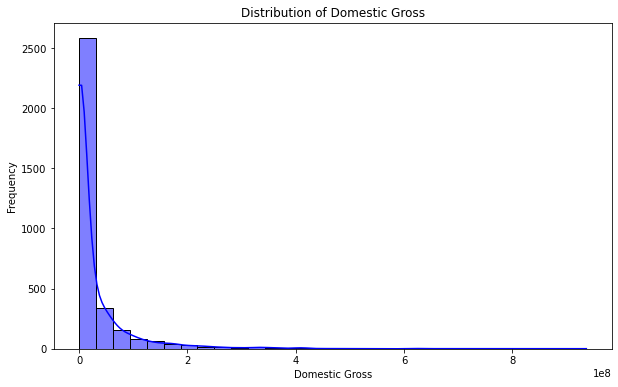

In [5239]:
data = box_office_mojo_df['domestic_gross']

# Plotting the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=30, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Domestic Gross')
plt.ylabel('Frequency')
plt.title('Distribution of Domestic Gross')

# Show plot
plt.show()


The graph isn't a normal distribution, the data is skewed to the right

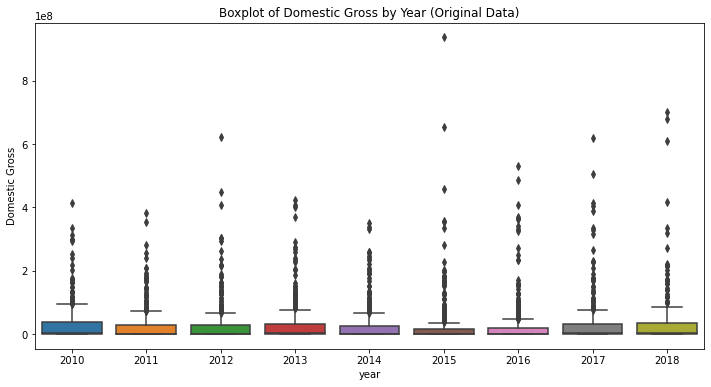

In [5240]:
# plot the outliers for domestic_gross and year using a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=box_office_mojo_df, x='year', y='domestic_gross')
plt.ylabel('Domestic Gross')
plt.title('Boxplot of Domestic Gross by Year (Original Data)')
plt.show()

As you can see from the data that there are a lot outliers in the data

In [5241]:
box_office_mojo_df

,title,studio,domestic_gross,year
0,Toy Story 3,BV,415000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,2010
3,Inception,WB,292600000.0,2010
4,Shrek Forever After,P/DW,238700000.0,2010
...,...,...,...,...
3382,The Quake,Magn.,6200.0,2018
3383,Edward II (2018 re-release),FM,4800.0,2018
3384,El Pacto,Sony,2500.0,2018
3385,The Swan,Synergetic,2400.0,2018


In [5242]:
box_office_mojo_df.describe()

,domestic_gross,year
count,3.376000e+03,3376.000000
mean,2.863480e+07,2013.960900
std,6.685139e+07,2.478759
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.300000e+06,2014.000000
75%,2.780000e+07,2016.000000
max,9.367000e+08,2018.000000


### Review:

We decided to keep these data points because these outliers represent natural variation in our dataset population (True Outliers). These points are not errors, they are the best grossing movies from 2014-2018. They should be kept to provide a variety of possible genres to recommend to out stakeholder.

This leaves us with a total of 1906 movies to examine later on

### imdb_movies_df

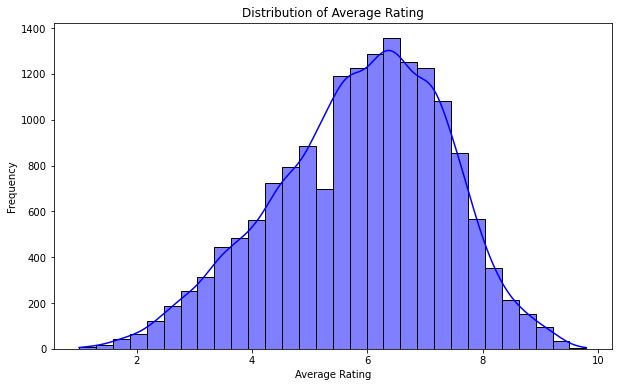

In [5243]:
# Example assuming 'domestic_gross' is a column in your DataFrame
data = imdb_movies_df['average_rating']

# Plotting the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=30, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Rating')

# Show plot
plt.show()

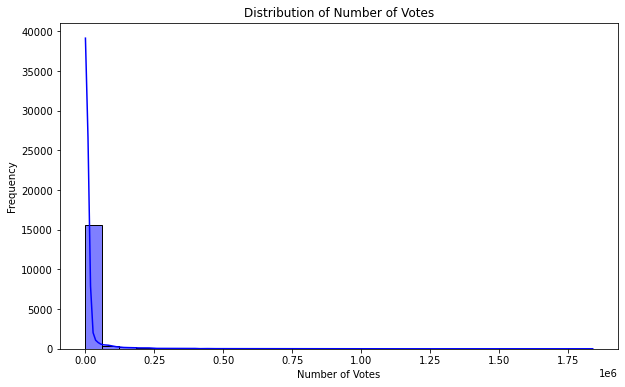

In [5244]:
# Example assuming 'domestic_gross' is a column in your DataFrame
data = imdb_movies_df['num_votes']

# Plotting the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=30, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Votes')

# Show plot
plt.show()

This graph is considered to be normally distributed

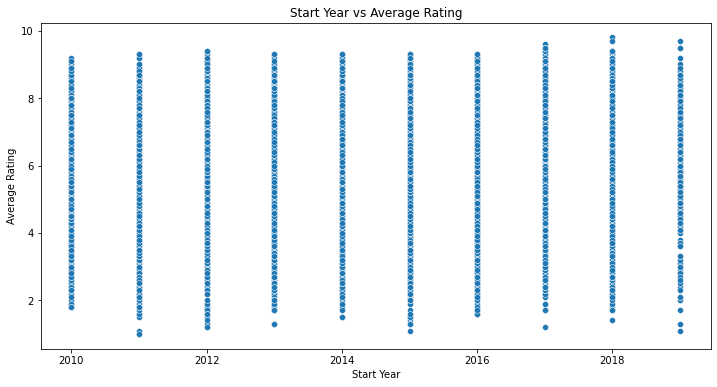

In [5245]:
# violin plot for start_year vs average_rating
plt.figure(figsize=(12, 6))
sns.scatterplot(data=imdb_movies_df, x='start_year', y='average_rating')
plt.xlabel('Start Year')
plt.ylabel('Average Rating')
plt.title('Start Year vs Average Rating')
plt.show()

In [5246]:
# detect outliers 
outliers = find_iqr_outliers(imdb_movies_df, 'average_rating')
outliers

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
396,Robin Hood: Ghosts of Sherwood,2012,116,1.7,468,"Action,Adventure,Mystery"
1248,Birdemic 2: The Resurrection,2013,90,1.7,3937,"Action,Comedy,Horror"
1431,Himmatwala,2013,150,1.7,7384,"Action,Comedy,Drama"
1665,The 6th Extinction,2012,90,1.7,277,Horror
1935,Rise of the Black Bat,2012,80,1.2,616,"Action,Sci-Fi"
2843,Captain Battle: Legacy War,2013,90,1.3,369,"Action,Sci-Fi,War"
3343,Futures Past,2012,120,1.3,33,"Action,Biography,History"
3816,Justin Bieber: Never Say Never,2011,105,1.6,74978,"Documentary,Music"
4735,Jurassic Shark,2012,75,1.6,3697,"Action,Adventure,Comedy"
6136,Kiara the Brave,2011,90,1.5,415,Animation


In [5247]:
# remove outliers
imdb_movies_df = remove_iqr_outliers(imdb_movies_df, 'average_rating')
imdb_movies_df

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
5,John Carter,2012,132,6.6,241792,"Action,Adventure,Sci-Fi"
9,Alice in Wonderland,2010,108,6.5,358813,"Adventure,Family,Fantasy"
12,Dark Buenos Aires,2010,90,3.4,123,Thriller
13,The Bourne Legacy,2012,135,6.7,268678,"Action,Adventure,Thriller"
...,...,...,...,...,...,...
30186,Devil's Tree: Rooted Evil,2018,76,4.9,1466,"Horror,Thriller"
30188,Girl/Girl Scene,2019,122,2.1,112,"Comedy,Drama,Romance"
30190,Coconut the Little Dragon 2 Into the Jungle,2018,Unknown,5.9,43,"Adventure,Animation,Comedy"
30192,Hail Satan?,2019,95,6.8,628,Documentary


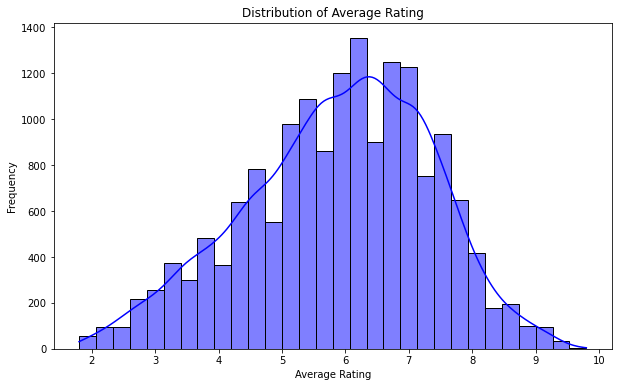

In [5248]:
data = imdb_movies_df['average_rating']

# Plotting the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=30, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Rating')

# Show plot
plt.show()

In [5249]:
# resets the index
imdb_movies_df.reset_index(drop=True, inplace=True)
imdb_movies_df

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
1,John Carter,2012,132,6.6,241792,"Action,Adventure,Sci-Fi"
2,Alice in Wonderland,2010,108,6.5,358813,"Adventure,Family,Fantasy"
3,Dark Buenos Aires,2010,90,3.4,123,Thriller
4,The Bourne Legacy,2012,135,6.7,268678,"Action,Adventure,Thriller"
...,...,...,...,...,...,...
16424,Devil's Tree: Rooted Evil,2018,76,4.9,1466,"Horror,Thriller"
16425,Girl/Girl Scene,2019,122,2.1,112,"Comedy,Drama,Romance"
16426,Coconut the Little Dragon 2 Into the Jungle,2018,Unknown,5.9,43,"Adventure,Animation,Comedy"
16427,Hail Satan?,2019,95,6.8,628,Documentary


In [5250]:
imdb_movies_df.describe()

,start_year,average_rating,num_votes
count,16429.000000,16429.000000,1.642900e+04
mean,2014.156796,5.882945,1.360481e+04
std,2.577814,1.465395,6.247570e+04
min,2010.000000,1.800000,3.100000e+01
25%,2012.000000,4.900000,8.400000e+01
50%,2014.000000,6.000000,2.960000e+02
75%,2016.000000,7.000000,1.798000e+03
max,2019.000000,9.800000,1.841066e+06


### Review:

We filtered out the outliers of ratings less than 2. This would provide a good reading to find better performing movies, but still include low rating movies to compare too. Looking at the average_rating and start_year we can see that in each year there are good rated movies and bad rated movies. This indicates that movies aren't necessary getting better as the years go on.

### imdb_people_df

In [5251]:
imdb_people_df

,primary_name,title,year,genres,birth_year,category,primary_profession
0,Colin Trevorrow,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
1,Colin Trevorrow,Jurassic World,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
2,Colin Trevorrow,Ebb Tide,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
3,Colin Trevorrow,Jurassic Park IV,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
4,Colin Trevorrow,Jurassic Park 4,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
...,...,...,...,...,...,...,...
8144,Robin Bain,The Last Exorcist,2019,Thriller,1980.0,director,"actress,writer,director"
8145,Christian Everhard,OJ: Guilty in Vegas,2017,Documentary,1976.0,producer,"producer,director,writer"
8146,Gabriel Sedgwick,Hail Satan?,2019,Documentary,1978.0,producer,"producer,assistant_director,miscellaneous"
8147,David Gere,Alien Warfare,2019,"Action,Sci-Fi",1975.0,producer,"producer,actor,casting_department"


In [5252]:
imdb_people_df.describe()

,year,birth_year
count,8149.000000,8149.000000
mean,2014.418824,1980.563382
std,2.728771,5.032912
min,2010.000000,1974.000000
25%,2012.000000,1977.000000
50%,2014.000000,1980.000000
75%,2017.000000,1984.000000
max,2022.000000,2004.000000


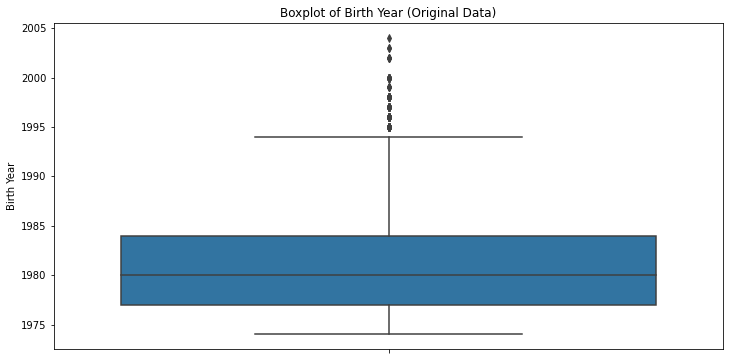

In [5253]:
# plot the outliers for birth_year using a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=imdb_people_df, y='birth_year')
plt.ylabel('Birth Year')
plt.title('Boxplot of Birth Year (Original Data)')
plt.show()

### Review

We are keeping all of the data in imdb_people_df, as it is a true representation of all people who were casted or a crew member. Keeping all of the data here would better represent the data, as it wouldn't make sense to drop anyone based on birth_year. For example: if a baby/small child was needed and we casted them out due to them being outliers, we wouldn't have any information on them.

### Numbers DB

In [5254]:
numbers_df

,release_date,movie,production_budget,domestic_gross,profit_loss
0,2009-12-18,Avatar,425000000.0,760507625.0,335507625.0
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,-169536125.0
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,-307237650.0
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,128405868.0
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,303181382.0
...,...,...,...,...,...
3858,2004-10-08,Primer,7000.0,424760.0,417760.0
3859,2006-05-26,Cavite,7000.0,70071.0,63071.0
3860,2004-12-31,The Mongol King,7000.0,900.0,-6100.0
3861,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,-3662.0


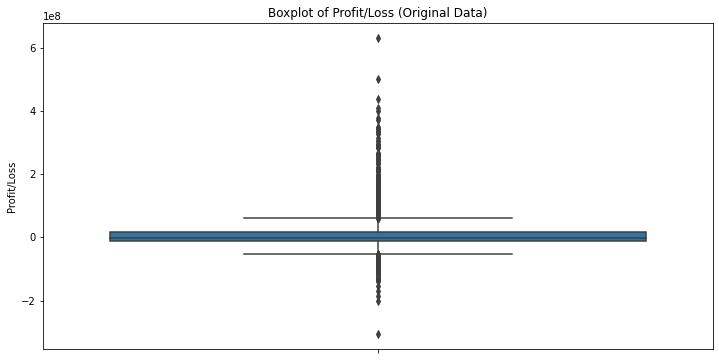

In [5255]:
# graph the outliers for profit/loss using a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=numbers_df, y='profit_loss')
plt.ylabel('Profit/Loss')
plt.title('Boxplot of Profit/Loss (Original Data)')
plt.show()

### Review

We decided to keep all of this data, because it represents "true outliers". We don't want to get rid of the best movies that profited the most.

### The Movies DB

In [5256]:
movie_db_df.columns

Index(['original_title', 'popularity', 'release_date', 'title', 'vote_average',
       'vote_count', 'genres'],
      dtype='object')

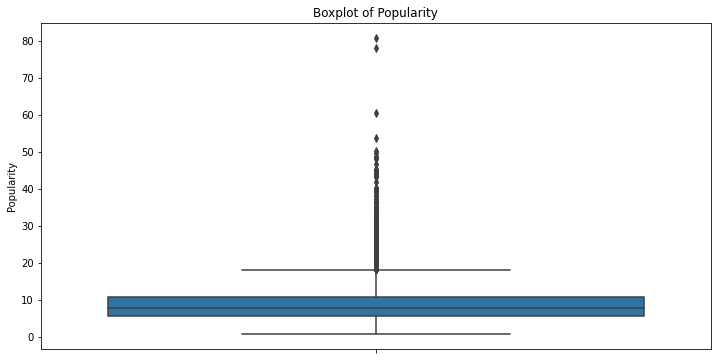

In [5257]:
# graph the outliers for popularity using a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=movie_db_df, y='popularity')
plt.ylabel('Popularity')
plt.title('Boxplot of Popularity')
plt.show()

### Review

We decided to keep all of these data points and not filter them out because they represent "true outliers". We want to compare all of the data together to get the best result.

### Filtered and Cleaned Datasets

In [5258]:
box_office_mojo_df

,title,studio,domestic_gross,year
0,Toy Story 3,BV,415000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,2010
3,Inception,WB,292600000.0,2010
4,Shrek Forever After,P/DW,238700000.0,2010
...,...,...,...,...
3382,The Quake,Magn.,6200.0,2018
3383,Edward II (2018 re-release),FM,4800.0,2018
3384,El Pacto,Sony,2500.0,2018
3385,The Swan,Synergetic,2400.0,2018


In [5259]:
box_office_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3376 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3376 non-null   object 
 1   studio          3376 non-null   object 
 2   domestic_gross  3376 non-null   float64
 3   year            3376 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 291.9+ KB


In [5260]:
box_office_mojo_df.describe()

,domestic_gross,year
count,3.376000e+03,3376.000000
mean,2.863480e+07,2013.960900
std,6.685139e+07,2.478759
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.300000e+06,2014.000000
75%,2.780000e+07,2016.000000
max,9.367000e+08,2018.000000


In [5261]:
imdb_movies_df

,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres
0,Jurassic World,2015,124,7.0,539338,"Action,Adventure,Sci-Fi"
1,John Carter,2012,132,6.6,241792,"Action,Adventure,Sci-Fi"
2,Alice in Wonderland,2010,108,6.5,358813,"Adventure,Family,Fantasy"
3,Dark Buenos Aires,2010,90,3.4,123,Thriller
4,The Bourne Legacy,2012,135,6.7,268678,"Action,Adventure,Thriller"
...,...,...,...,...,...,...
16424,Devil's Tree: Rooted Evil,2018,76,4.9,1466,"Horror,Thriller"
16425,Girl/Girl Scene,2019,122,2.1,112,"Comedy,Drama,Romance"
16426,Coconut the Little Dragon 2 Into the Jungle,2018,Unknown,5.9,43,"Adventure,Animation,Comedy"
16427,Hail Satan?,2019,95,6.8,628,Documentary


In [5262]:
imdb_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16429 entries, 0 to 16428
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    16429 non-null  object 
 1   start_year       16429 non-null  int64  
 2   runtime_minutes  16429 non-null  object 
 3   average_rating   16429 non-null  float64
 4   num_votes        16429 non-null  int64  
 5   genres           16429 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 770.2+ KB


In [5263]:
imdb_movies_df.describe()

,start_year,average_rating,num_votes
count,16429.000000,16429.000000,1.642900e+04
mean,2014.156796,5.882945,1.360481e+04
std,2.577814,1.465395,6.247570e+04
min,2010.000000,1.800000,3.100000e+01
25%,2012.000000,4.900000,8.400000e+01
50%,2014.000000,6.000000,2.960000e+02
75%,2016.000000,7.000000,1.798000e+03
max,2019.000000,9.800000,1.841066e+06


In [5264]:
imdb_people_df

,primary_name,title,year,genres,birth_year,category,primary_profession
0,Colin Trevorrow,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
1,Colin Trevorrow,Jurassic World,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
2,Colin Trevorrow,Ebb Tide,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
3,Colin Trevorrow,Jurassic Park IV,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
4,Colin Trevorrow,Jurassic Park 4,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
...,...,...,...,...,...,...,...
8144,Robin Bain,The Last Exorcist,2019,Thriller,1980.0,director,"actress,writer,director"
8145,Christian Everhard,OJ: Guilty in Vegas,2017,Documentary,1976.0,producer,"producer,director,writer"
8146,Gabriel Sedgwick,Hail Satan?,2019,Documentary,1978.0,producer,"producer,assistant_director,miscellaneous"
8147,David Gere,Alien Warfare,2019,"Action,Sci-Fi",1975.0,producer,"producer,actor,casting_department"


In [5265]:
imdb_people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8149 entries, 0 to 8148
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   primary_name        8149 non-null   object 
 1   title               8149 non-null   object 
 2   year                8149 non-null   int64  
 3   genres              8107 non-null   object 
 4   birth_year          8149 non-null   float64
 5   category            8149 non-null   object 
 6   primary_profession  8149 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 445.8+ KB


In [5266]:
imdb_people_df.describe()

,year,birth_year
count,8149.000000,8149.000000
mean,2014.418824,1980.563382
std,2.728771,5.032912
min,2010.000000,1974.000000
25%,2012.000000,1977.000000
50%,2014.000000,1980.000000
75%,2017.000000,1984.000000
max,2022.000000,2004.000000


In [5267]:
numbers_df

,release_date,movie,production_budget,domestic_gross,profit_loss
0,2009-12-18,Avatar,425000000.0,760507625.0,335507625.0
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,-169536125.0
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,-307237650.0
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,128405868.0
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,303181382.0
...,...,...,...,...,...
3858,2004-10-08,Primer,7000.0,424760.0,417760.0
3859,2006-05-26,Cavite,7000.0,70071.0,63071.0
3860,2004-12-31,The Mongol King,7000.0,900.0,-6100.0
3861,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,-3662.0


In [5268]:
numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3863 entries, 0 to 3862
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       3863 non-null   datetime64[ns]
 1   movie              3863 non-null   object        
 2   production_budget  3863 non-null   float64       
 3   domestic_gross     3863 non-null   float64       
 4   profit_loss        3863 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 151.0+ KB


In [5269]:
numbers_df.describe()

,production_budget,domestic_gross,profit_loss
count,3.863000e+03,3.863000e+03,3.863000e+03
mean,3.803566e+07,4.748882e+07,9.453165e+06
std,4.708862e+07,7.415705e+07,5.164515e+07
min,1.100000e+03,3.880000e+02,-3.072376e+08
25%,7.750000e+06,3.160708e+06,-1.051224e+07
50%,2.000000e+07,2.147168e+07,-5.408890e+05
75%,5.000000e+07,5.836636e+07,1.843035e+07
max,4.250000e+08,9.366622e+08,6.306622e+08


In [5270]:
movie_db_df

,original_title,popularity,release_date,title,vote_average,vote_count,genres
0,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure, Family, Fantasy"
1,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Adventure, Animation, Family, Fantasy"
2,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Action, Adventure, Science Fiction"
3,Inception,27.920,2010-07-16,Inception,8.3,22186,"Action, Adventure, Science Fiction"
4,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,"Adventure, Family, Fantasy"
...,...,...,...,...,...,...,...
5203,Adventures in Public School,3.026,2018-02-07,Adventures in Public School,5.7,36,Comedy
5204,Feminists: What Were They Thinking?,2.871,2018-02-19,Feminists: What Were They Thinking?,8.2,42,Documentary
5205,Bilal: A New Breed of Hero,2.707,2018-02-02,Bilal: A New Breed of Hero,6.8,54,"Action, Adventure, Animation"
5206,The Devil and Father Amorth,1.850,2018-04-20,The Devil and Father Amorth,5.3,40,"Documentary, Horror"


In [5271]:
movie_db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5208 entries, 0 to 5207
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   original_title  5208 non-null   object        
 1   popularity      5208 non-null   float64       
 2   release_date    5208 non-null   datetime64[ns]
 3   title           5208 non-null   object        
 4   vote_average    5208 non-null   float64       
 5   vote_count      5208 non-null   int64         
 6   genres          5208 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 284.9+ KB


In [5272]:
movie_db_df.describe()

,popularity,vote_average,vote_count
count,5208.000000,5208.000000,5208.000000
mean,9.044014,6.134793,890.092166
std,6.072036,0.976438,1967.959476
min,0.600000,1.600000,31.000000
25%,5.664750,5.500000,58.000000
50%,7.636000,6.100000,154.000000
75%,10.672000,6.800000,683.250000
max,80.773000,8.900000,22186.000000


### Correlation Analysis

In [5273]:
# function for finding the scatter plot between two columns
def scatter_plot(df, x, y):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x=x, y=y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{x} vs {y}')
    plt.show()

# function for finding the correlation matrix
def correlation_matrix(df):
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

### Box Office Mojo

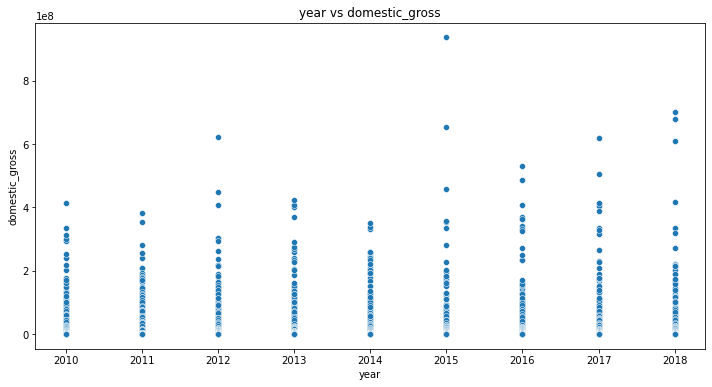

In [5274]:
# scatter plot for year vs domestic_gross
scatter_plot(box_office_mojo_df, 'year', 'domestic_gross')

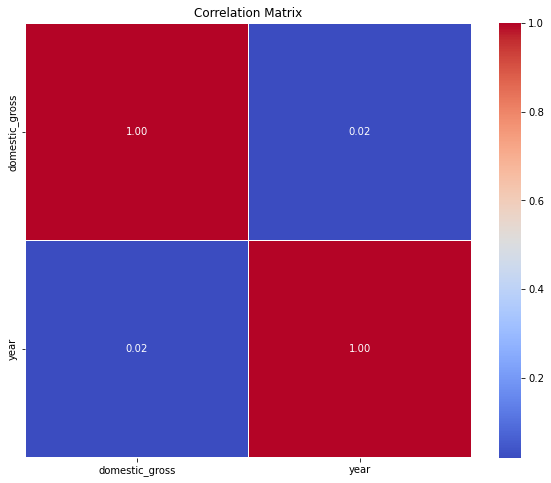

In [5275]:
# correlation matrix for box_office_mojo_df
correlation_matrix(box_office_mojo_df)

In [5276]:
# perform chi-square test for year and studio columns
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(box_office_mojo_df['year'], box_office_mojo_df['studio']))
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")


Chi-square value: 3146.537897752055
P-value: 1.9277989059427703e-51
Degrees of freedom: 2032
Expected frequencies: [[0.09686019 0.19372038 4.74614929 ... 1.35604265 0.09686019 1.54976303]
 [0.11759479 0.23518957 5.76214455 ... 1.64632701 0.11759479 1.88151659]
 [0.117891   0.23578199 5.77665877 ... 1.65047393 0.117891   1.88625592]
 ...
 [0.12885071 0.25770142 6.31368483 ... 1.80390995 0.12885071 2.06161137]
 [0.09478673 0.18957346 4.64454976 ... 1.32701422 0.09478673 1.51658768]
 [0.09123223 0.18246445 4.47037915 ... 1.27725118 0.09123223 1.45971564]]


### IMDB Movies

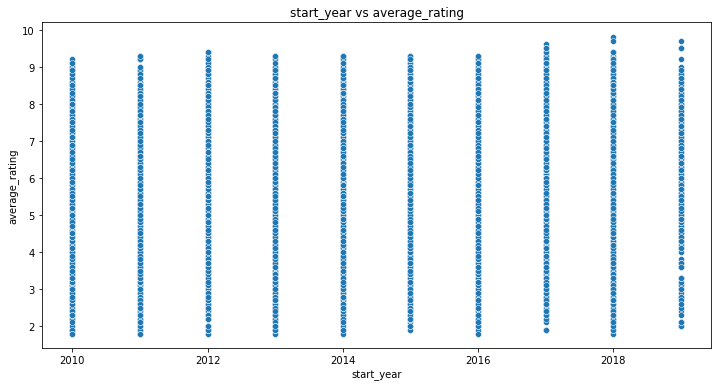

In [5277]:
# scatter plot for start_year vs average_rating
scatter_plot(imdb_movies_df, 'start_year', 'average_rating')

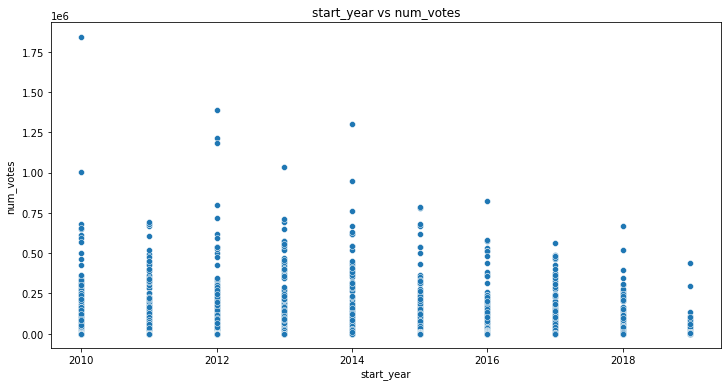

In [5278]:
# scatter plot for start_year vs num_votes
scatter_plot(imdb_movies_df, 'start_year', 'num_votes')

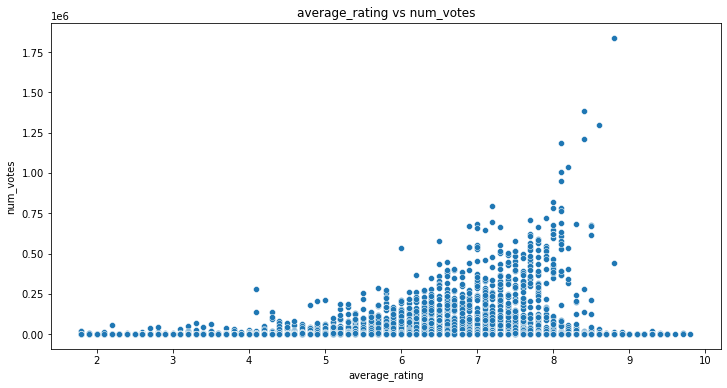

In [5279]:
# scatter plot for average_rating vs num_votes
scatter_plot(imdb_movies_df, 'average_rating', 'num_votes')

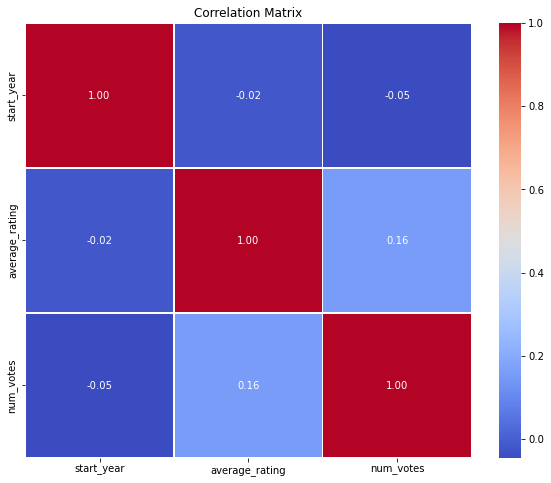

In [5280]:
# correlation matrix for imdb_movies_df
correlation_matrix(imdb_movies_df)

### IMDB People

In [5281]:
# perform chi-square test for category and primary_profession columns
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(imdb_people_df['category'], imdb_people_df['primary_profession']))
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")

Chi-square value: 4747.056249060855
P-value: 0.0
Degrees of freedom: 915
Expected frequencies: [[1.17683151 1.76524727 0.58841576 ... 0.58841576 0.58841576 0.58841576]
 [0.82316849 1.23475273 0.41158424 ... 0.41158424 0.41158424 0.41158424]]


### Numbers

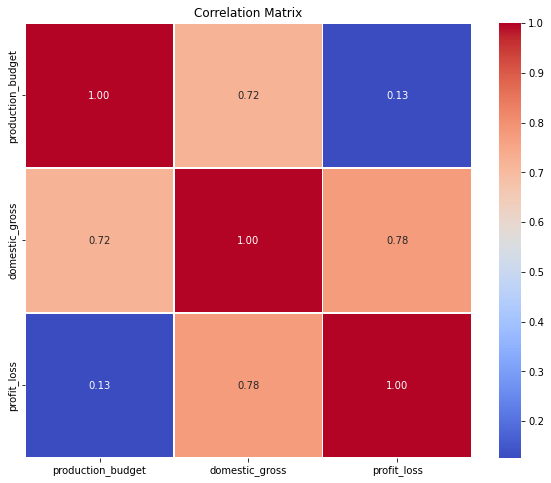

In [5282]:
# correlation matrix for numbers_df
correlation_matrix(numbers_df)

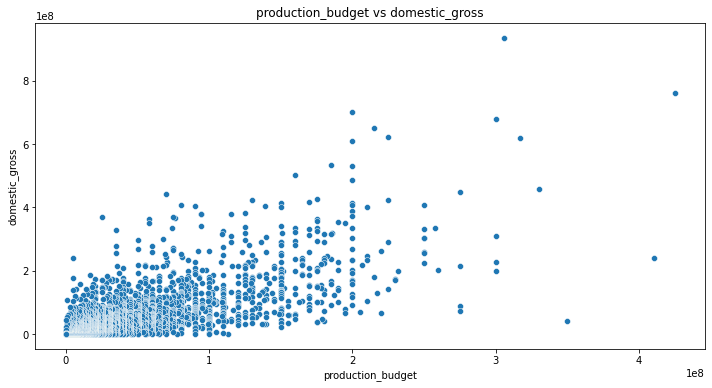

In [5283]:
# scatter plot for production_budget vs profit_loss
scatter_plot(numbers_df, 'production_budget', 'domestic_gross')

### The Movies

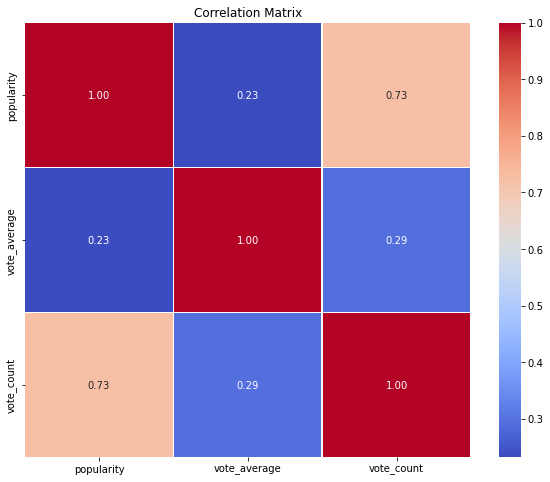

In [5284]:
# correlation matrix for movie_db_df
correlation_matrix(movie_db_df)

In [5285]:
# perform chi-square test for genres and popularity columns
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(movie_db_df['genres'], movie_db_df['popularity']))

# print the results
print(f"Chi-square: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected: ")
print(expected)

Chi-square: 2870144.002464675
P-value: 0.0
Degrees of Freedom: 2623406
Expected: 
[[0.01056068 0.00096006 0.00096006 ... 0.00096006 0.00096006 0.00096006]
 [0.08659754 0.0078725  0.0078725  ... 0.0078725  0.0078725  0.0078725 ]
 [0.02534562 0.00230415 0.00230415 ... 0.00230415 0.00230415 0.00230415]
 ...
 [0.00211214 0.00019201 0.00019201 ... 0.00019201 0.00019201 0.00019201]
 [0.00211214 0.00019201 0.00019201 ... 0.00019201 0.00019201 0.00019201]
 [0.00844854 0.00076805 0.00076805 ... 0.00076805 0.00076805 0.00076805]]


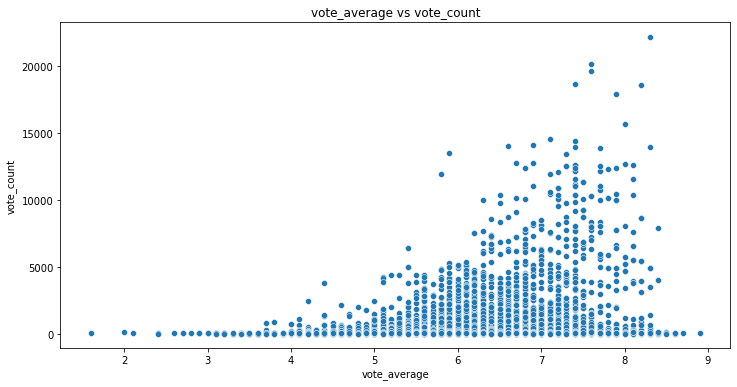

In [5286]:
# graph for vote_count and vote_average
scatter_plot(movie_db_df, 'vote_average', 'vote_count')

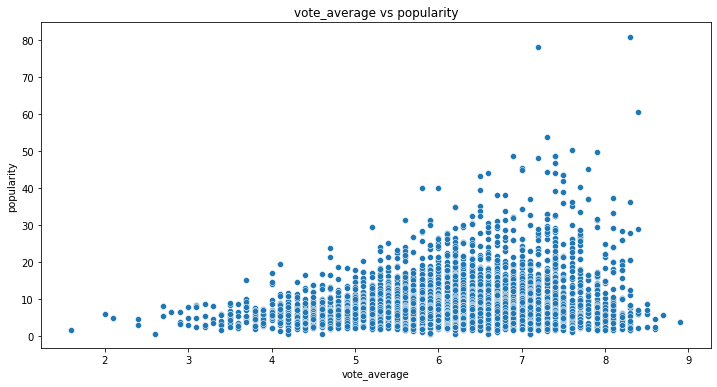

In [5287]:
# graph for popularity and vote_average
scatter_plot(movie_db_df, 'vote_average', 'popularity')

In [5288]:
movie_db_df.head()

,original_title,popularity,release_date,title,vote_average,vote_count,genres
0,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure, Family, Fantasy"
1,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Adventure, Animation, Family, Fantasy"
2,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Action, Adventure, Science Fiction"
3,Inception,27.920,2010-07-16,Inception,8.3,22186,"Action, Adventure, Science Fiction"
4,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,"Adventure, Family, Fantasy"


## Feature Engineering & Analysis

In [5289]:
# seperate the year, month, and date from the release_date column
numbers_df['year'] = numbers_df['release_date'].dt.year
numbers_df['month'] = numbers_df['release_date'].dt.month
numbers_df['day'] = numbers_df['release_date'].dt.day

# drop the release_date column
numbers_df.drop(columns=['release_date'], inplace=True)

In [5290]:
movie_db_df.head()

,original_title,popularity,release_date,title,vote_average,vote_count,genres
0,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure, Family, Fantasy"
1,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Adventure, Animation, Family, Fantasy"
2,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Action, Adventure, Science Fiction"
3,Inception,27.920,2010-07-16,Inception,8.3,22186,"Action, Adventure, Science Fiction"
4,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,"Adventure, Family, Fantasy"


In [5291]:
# combine box_office_mojo_df and imdb_movies_df, movie_db_df and numbers_df
combined_movie_info = pd.merge(box_office_mojo_df, imdb_movies_df, left_on='title', right_on='primary_title', how='inner')
combined_movie_info = pd.merge(combined_movie_info, numbers_df, left_on='title', right_on='movie', how='inner')
combined_movie_info = pd.merge(combined_movie_info, movie_db_df, left_on='title', right_on='original_title', how='inner')

combined_movie_info.head()

,title_x,studio,domestic_gross_x,year_x,primary_title,start_year,runtime_minutes,average_rating,num_votes,genres_x,...,year_y,month,day,original_title,popularity,release_date,title_y,vote_average,vote_count,genres_y
0,Toy Story 3,BV,415000000.0,2010,Toy Story 3,2010,103,8.3,682218,"Adventure,Animation,Comedy",...,2010,6,18,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340,"Animation, Comedy, Family"
1,Inception,WB,292600000.0,2010,Inception,2010,148,8.8,1841066,"Action,Adventure,Sci-Fi",...,2010,7,16,Inception,27.920,2010-07-16,Inception,8.3,22186,"Action, Adventure, Science Fiction"
2,Shrek Forever After,P/DW,238700000.0,2010,Shrek Forever After,2010,93,6.3,167532,"Adventure,Animation,Comedy",...,2010,5,21,Shrek Forever After,15.041,2010-05-16,Shrek Forever After,6.1,3843,"Adventure, Animation, Comedy, Family, Fantasy"
3,The Twilight Saga: Eclipse,Sum.,300500000.0,2010,The Twilight Saga: Eclipse,2010,124,5.0,211733,"Adventure,Drama,Fantasy",...,2010,6,30,The Twilight Saga: Eclipse,20.340,2010-06-23,The Twilight Saga: Eclipse,6.0,4909,"Adventure, Drama, Fantasy, Romance"
4,Iron Man 2,Par.,312400000.0,2010,Iron Man 2,2010,124,7.0,657690,"Action,Adventure,Sci-Fi",...,2010,5,7,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Action, Adventure, Science Fiction"


In [5292]:
#  finding average rating per movie
combined_movie_info['total_rating'] = (combined_movie_info['average_rating'] * combined_movie_info['num_votes'] + combined_movie_info['vote_average'] * combined_movie_info['vote_count']) / (combined_movie_info['num_votes'] + combined_movie_info['vote_count'])
combined_movie_info['total_num_votes'] = combined_movie_info['num_votes'] + combined_movie_info['vote_count']

In [5293]:
# drop unnecessary columns
combined_movie_info.drop(columns=['domestic_gross_x', 'runtime_minutes', 'start_year', 'year_x', 'primary_title', 'genres_y', 'title_y', 'vote_count', 'vote_average', 'release_date', 'movie', 'original_title', 'average_rating', 'num_votes'], inplace=True)

# rename columns
combined_movie_info.rename(columns={'title_x': 'title', 'year_y': 'year', 'domestic_gross_y': 'domestic_gross', 'genres_x': 'genres', 'total_rating': 'average_rating', 'total_num_votes': 'num_votes'}, inplace=True)

combined_movie_info.head()

,title,studio,genres,production_budget,domestic_gross,profit_loss,year,month,day,popularity,average_rating,num_votes
0,Toy Story 3,BV,"Adventure,Animation,Comedy",200000000.0,415004880.0,215004880.0,2010,6,18,24.445,8.292754,690558
1,Inception,WB,"Action,Adventure,Sci-Fi",160000000.0,292576195.0,132576195.0,2010,7,16,27.920,8.794046,1863252
2,Shrek Forever After,P/DW,"Adventure,Animation,Comedy",165000000.0,238736787.0,73736787.0,2010,5,21,15.041,6.295515,171375
3,The Twilight Saga: Eclipse,Sum.,"Adventure,Drama,Fantasy",68000000.0,300531751.0,232531751.0,2010,6,30,20.340,5.022660,216642
4,Iron Man 2,Par.,"Action,Adventure,Sci-Fi",170000000.0,312433331.0,142433331.0,2010,5,7,28.515,6.996308,670058


In [5294]:
# Split the 'genres' column into separate columns
combined_movie_info[['genre1', 'genre2', 'genre3']] = combined_movie_info['genres'].str.split(',', expand=True)

# Ensure each movie has exactly three genres
combined_movie_info['genre2'] = combined_movie_info['genre2'].fillna('None')  # Fill with 'None' if genre2 is missing
combined_movie_info['genre3'] = combined_movie_info['genre3'].fillna('None')  # Fill with 'None' if genre3 is missing

# drop genres column
combined_movie_info.drop(columns=['genres'], inplace=True)

# filter year to be from 2000-2018
combined_movie_info = combined_movie_info[(combined_movie_info['year'] >= 2010) & (combined_movie_info['year'] <= 2018)]

combined_movie_info.head()

,title,studio,production_budget,domestic_gross,profit_loss,year,month,day,popularity,average_rating,num_votes,genre1,genre2,genre3
0,Toy Story 3,BV,200000000.0,415004880.0,215004880.0,2010,6,18,24.445,8.292754,690558,Adventure,Animation,Comedy
1,Inception,WB,160000000.0,292576195.0,132576195.0,2010,7,16,27.920,8.794046,1863252,Action,Adventure,Sci-Fi
2,Shrek Forever After,P/DW,165000000.0,238736787.0,73736787.0,2010,5,21,15.041,6.295515,171375,Adventure,Animation,Comedy
3,The Twilight Saga: Eclipse,Sum.,68000000.0,300531751.0,232531751.0,2010,6,30,20.340,5.022660,216642,Adventure,Drama,Fantasy
4,Iron Man 2,Par.,170000000.0,312433331.0,142433331.0,2010,5,7,28.515,6.996308,670058,Action,Adventure,Sci-Fi


### Correlation Analysis for combined dataset

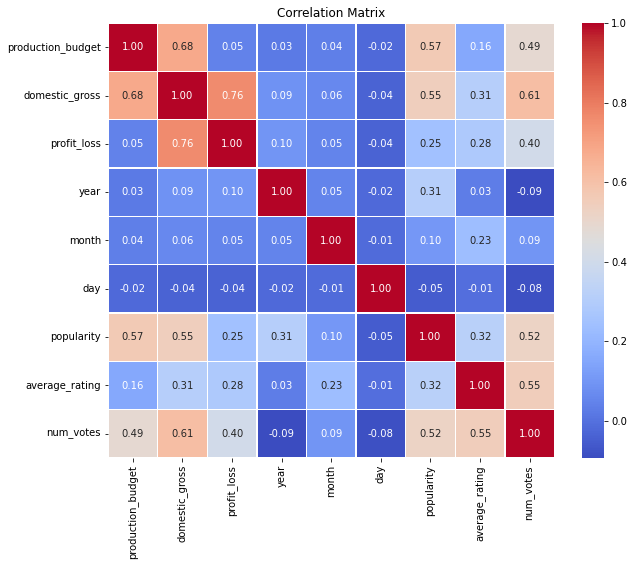

In [5572]:
# correlation matrix for combined_movie_info
correlation_matrix(combined_movie_info)

In [5575]:
# chi-square test for studio and genre1 columns
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(combined_movie_info['studio'], combined_movie_info['genre1']))
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

Chi-square value: 1875.255111815662
P-value: 2.8207253004847842e-71
Degrees of freedom: 897


In [5581]:
# chi-square test for popularity and genre1 columns
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(combined_movie_info['popularity'], combined_movie_info['genre1']))
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

Chi-square value: 12977.3093452635
P-value: 0.03540448874712205
Degrees of freedom: 12688


In [5577]:
# chi-square test for studio and profit columns
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(combined_movie_info['studio'], combined_movie_info['profit_loss'] > 0))
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

Chi-square value: 126.57470670577788
P-value: 2.9438745385862837e-05
Degrees of freedom: 69


In [5578]:
# chi-square test for genre and average_rating columns
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(combined_movie_info['genre1'], combined_movie_info['average_rating'] > 6))
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

Chi-square value: 91.72355358636452
P-value: 6.53636353322546e-14
Degrees of freedom: 13


In [5579]:
# chi-square test for profit/loss and genre combination
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(combined_movie_info['profit_loss'] > 0, combined_movie_info['genre1']))
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

Chi-square value: 63.70499749373626
P-value: 1.1320728627765802e-08
Degrees of freedom: 13


In [5584]:
# chi-square test for month and domestic_gross columns
chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(combined_movie_info['month'], combined_movie_info['domestic_gross'] > 1000000))
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

Chi-square value: 19.57041036474417
P-value: 0.05159199090575367
Degrees of freedom: 11


In [5295]:
combined_movie_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1159 entries, 0 to 1159
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1159 non-null   object 
 1   studio             1159 non-null   object 
 2   production_budget  1159 non-null   float64
 3   domestic_gross     1159 non-null   float64
 4   profit_loss        1159 non-null   float64
 5   year               1159 non-null   int64  
 6   month              1159 non-null   int64  
 7   day                1159 non-null   int64  
 8   popularity         1159 non-null   float64
 9   average_rating     1159 non-null   float64
 10  num_votes          1159 non-null   int64  
 11  genre1             1159 non-null   object 
 12  genre2             1159 non-null   object 
 13  genre3             1159 non-null   object 
dtypes: float64(5), int64(4), object(5)
memory usage: 135.8+ KB


### Feature Engineering - further analysis

In [5296]:
# find the gross for each studio
studio_gross = combined_movie_info.groupby('studio')['domestic_gross'].sum().sort_values(ascending=False).reset_index()

top_10_studio_gross = studio_gross.head(10)
top_10_studio_gross

,studio,domestic_gross
0,BV,1.651706e+10
1,Uni.,1.215715e+10
2,Fox,1.042088e+10
3,WB,1.014355e+10
4,Sony,7.675558e+09
5,Par.,5.898497e+09
6,WB (NL),4.007895e+09
7,LGF,3.690897e+09
8,P/DW,1.682915e+09
9,LG/S,1.548796e+09


In [5297]:
# find profit for each studio
studio_profit = combined_movie_info.groupby('studio')['profit_loss'].sum().sort_values(ascending=False).reset_index()

top_10_studio_profit = studio_profit.head(10)
top_10_studio_profit

,studio,profit_loss
0,BV,5.188557e+09
1,Uni.,4.352945e+09
2,Sony,2.247558e+09
3,Fox,2.063879e+09
4,WB (NL),1.718295e+09
5,LGF,1.472097e+09
6,WB,1.277050e+09
7,Par.,1.212497e+09
8,FoxS,4.597761e+08
9,Wein.,3.772417e+08


In [5298]:
# find year v studio v gross
year_studio_gross = combined_movie_info.groupby(['year', 'studio'])['domestic_gross'].sum().reset_index()

# find the top 10 studios with the highest gross
ten_studio_gross = year_studio_gross.groupby('studio')['domestic_gross'].sum().sort_values(ascending=False).head(10).index

# filter the year_studio_gross dataframe to only include the top 10 studios
top_10_year_studio_gross = year_studio_gross[year_studio_gross['studio'].isin(ten_studio_gross)]
top_10_year_studio_gross

,year,studio,domestic_gross
3,2010,BV,8.273298e+08
7,2010,Fox,7.853191e+08
11,2010,LGF,3.246487e+08
16,2010,P/DW,6.777602e+08
17,2010,Par.,9.848540e+08
...,...,...,...
236,2018,Par.,4.943924e+08
240,2018,Sony,4.815817e+08
242,2018,Uni.,1.357526e+09
244,2018,WB,1.383480e+09


In [5299]:
# find year v studio v profit
year_studio_profit = combined_movie_info.groupby(['year', 'studio'])['profit_loss'].sum().reset_index()

# find the top 10 studios with the highest profit
top_10_year_studio_profit = year_studio_profit.groupby('studio')['profit_loss'].sum().sort_values(ascending=False).head(10).reset_index()
top_10_year_studio_profit

,studio,profit_loss
0,BV,5.188557e+09
1,Uni.,4.352945e+09
2,Sony,2.247558e+09
3,Fox,2.063879e+09
4,WB (NL),1.718295e+09
5,LGF,1.472097e+09
6,WB,1.277050e+09
7,Par.,1.212497e+09
8,FoxS,4.597761e+08
9,Wein.,3.772417e+08


In [5300]:
# find the trend of genre over the years
genre_trend = combined_movie_info.groupby(['year', 'genre1'])['domestic_gross'].sum().reset_index()

# find the top 10 genres
top_10_genre_trend = genre_trend.groupby('genre1')['domestic_gross'].sum().sort_values(ascending=False).head(10).reset_index()
top_10_genre_trend

,genre1,domestic_gross
0,Action,3.788488e+10
1,Adventure,1.659871e+10
2,Comedy,1.041331e+10
3,Drama,6.627885e+09
4,Biography,4.498544e+09
5,Horror,3.345026e+09
6,Crime,2.505671e+09
7,Animation,1.254192e+09
8,Mystery,3.342666e+08
9,Thriller,2.825515e+08


In [5301]:
# find genre v average_rating
genre_rating = combined_movie_info.groupby('genre1')['average_rating'].mean().sort_values(ascending=False).reset_index()

top_10_genre_rating = genre_rating.head(10)
top_10_genre_rating

,genre1,average_rating
0,Mystery,7.497526
1,Sport,7.173759
2,Biography,7.141097
3,Romance,7.094321
4,Animation,6.984480
5,Crime,6.811276
6,Documentary,6.783311
7,Drama,6.716969
8,Adventure,6.487306
9,Action,6.451502


In [5302]:
# find number of votes for each genre
genre_votes = combined_movie_info.groupby('genre1')['num_votes'].sum().sort_values(ascending=False).reset_index()
genre_votes

,genre1,num_votes
0,Action,77280221
1,Adventure,21997521
2,Drama,21878253
3,Comedy,20694532
4,Biography,13277461
5,Crime,8421891
6,Horror,6787283
7,Mystery,1841879
8,Animation,1233975
9,Romance,230231


In [5303]:
# find genre v gross
genre_gross = combined_movie_info.groupby('genre1')['domestic_gross'].sum().sort_values(ascending=False).reset_index()

top_10_genre_gross = genre_gross.head(10)
top_10_genre_gross

,genre1,domestic_gross
0,Action,3.788488e+10
1,Adventure,1.659871e+10
2,Comedy,1.041331e+10
3,Drama,6.627885e+09
4,Biography,4.498544e+09
5,Horror,3.345026e+09
6,Crime,2.505671e+09
7,Animation,1.254192e+09
8,Mystery,3.342666e+08
9,Thriller,2.825515e+08


In [5304]:
# find genre v profit
genre_profit = combined_movie_info.groupby('genre1')['profit_loss'].sum().sort_values(ascending=False).reset_index()

top_10_genre_profit = genre_profit.head(10)
top_10_genre_profit

,genre1,profit_loss
0,Action,4.967685e+09
1,Comedy,4.523187e+09
2,Adventure,3.922311e+09
3,Horror,2.523676e+09
4,Drama,2.359075e+09
5,Biography,1.960874e+09
6,Crime,8.192706e+08
7,Animation,6.851916e+08
8,Mystery,1.772666e+08
9,Thriller,1.264515e+08


In [5305]:
# find genre v production_budget
genre_budget = combined_movie_info.groupby('genre1')['production_budget'].sum().sort_values(ascending=False).reset_index()

top_10_genre_budget = genre_budget.head(10)
top_10_genre_budget

,genre1,production_budget
0,Action,3.291720e+10
1,Adventure,1.267640e+10
2,Comedy,5.890120e+09
3,Drama,4.268810e+09
4,Biography,2.537670e+09
5,Crime,1.686400e+09
6,Horror,8.213500e+08
7,Animation,5.690000e+08
8,Documentary,2.329000e+08
9,Mystery,1.570000e+08


In [5306]:
# find out what genre each studio produces
studio_genre = combined_movie_info.groupby(['studio', 'genre1'])['domestic_gross'].sum().reset_index()
studio_genre

,studio,genre1,domestic_gross
0,A24,Adventure,4873701.0
1,A24,Biography,42241232.0
2,A24,Comedy,139002532.0
3,A24,Crime,11498268.0
4,A24,Drama,106364939.0
...,...,...,...
232,Wein.,Action,28802665.0
233,Wein.,Biography,259080353.0
234,Wein.,Comedy,399895919.0
235,Wein.,Crime,160577664.0


In [5307]:
# count the number of action movies per studio
action_movies = combined_movie_info[combined_movie_info['genre1'].str.contains('Action', na=False)]

studio_action_counts = action_movies['studio'].value_counts()

studio_action_counts.head(10)

Uni.     49
WB       47
Fox      40
Sony     34
BV       30
LGF      26
Par.     21
LG/S     16
Rela.     9
SGem      9
Name: studio, dtype: int64

In [5308]:
# count the number of adventure movies per studio
adventure_movies = combined_movie_info[combined_movie_info['genre1'].str.contains('Adventure', na=False)]

studio_adventure_counts = adventure_movies['studio'].value_counts()

studio_adventure_counts.head(10)

BV         29
Fox        28
Sony       15
Uni.       13
WB          9
Par.        8
WB (NL)     6
FoxS        5
Focus       4
Rela.       3
Name: studio, dtype: int64

In [5309]:
# month v gross
month_gross = combined_movie_info.groupby('month')['domestic_gross'].sum().reset_index()
month_gross

,month,domestic_gross
0,1,2.799835e+09
1,2,4.686596e+09
2,3,5.249842e+09
3,4,4.447611e+09
4,5,7.817083e+09
5,6,1.113071e+10
6,7,8.391985e+09
7,8,4.632775e+09
8,9,4.148813e+09
9,10,4.942153e+09


In [5310]:
combined_movie_info.head()

,title,studio,production_budget,domestic_gross,profit_loss,year,month,day,popularity,average_rating,num_votes,genre1,genre2,genre3
0,Toy Story 3,BV,200000000.0,415004880.0,215004880.0,2010,6,18,24.445,8.292754,690558,Adventure,Animation,Comedy
1,Inception,WB,160000000.0,292576195.0,132576195.0,2010,7,16,27.920,8.794046,1863252,Action,Adventure,Sci-Fi
2,Shrek Forever After,P/DW,165000000.0,238736787.0,73736787.0,2010,5,21,15.041,6.295515,171375,Adventure,Animation,Comedy
3,The Twilight Saga: Eclipse,Sum.,68000000.0,300531751.0,232531751.0,2010,6,30,20.340,5.022660,216642,Adventure,Drama,Fantasy
4,Iron Man 2,Par.,170000000.0,312433331.0,142433331.0,2010,5,7,28.515,6.996308,670058,Action,Adventure,Sci-Fi


In [5311]:
# for each genre find the ratings for each film into a new dataframe
genre_rating = combined_movie_info.groupby('genre1')['average_rating'].mean().reset_index()
genre_rating

,genre1,average_rating
0,Action,6.451502
1,Adventure,6.487306
2,Animation,6.984480
3,Biography,7.141097
4,Comedy,6.239003
5,Crime,6.811276
6,Documentary,6.783311
7,Drama,6.716969
8,Fantasy,5.955929
9,Horror,5.708187


In [5312]:
genres = ['genre1', 'genre2', 'genre3']
df_long = combined_movie_info.melt(id_vars=['title', 'studio', 'production_budget', 'domestic_gross', 'profit_loss', 'year', 'month', 'day', 'popularity', 'average_rating', 'num_votes'], value_vars=genres, var_name='genre_type', value_name='genre')

# Drop NaN genres (if any)
df_long = df_long.dropna(subset=['genre'])

# Group by genre and calculate the weighted average rating
df_long['total_score'] = df_long['average_rating'] * df_long['num_votes']
genre_group = df_long.groupby('genre').apply(lambda x: pd.Series({
    'weighted_average_rating': x['total_score'].sum() / x['num_votes'].sum(),
    'total_votes': x['num_votes'].sum()
})).reset_index()

genre_group_sorted = genre_group.sort_values(by='genre').reset_index(drop=True)
genre_group_sorted

,genre,weighted_average_rating,total_votes
0,Action,7.011026,77280221.0
1,Adventure,7.150943,72934505.0
2,Animation,7.330794,13817599.0
3,Biography,7.617858,16843872.0
4,Comedy,6.914036,48951715.0
5,Crime,7.112561,25477007.0
6,Documentary,7.828140,131018.0
7,Drama,7.317616,73353548.0
8,Family,6.817203,5722523.0
9,Fantasy,6.751754,17138363.0


### How does each genre rank?

In [5313]:
df = pd.read_csv('extractedData/tmdb.movies.csv')

# Filter movies released after 2010
df['release_date'] = pd.to_datetime(df['release_date'])
df = df[df['release_date'].dt.year > 2010]

# Define genre IDs and their corresponding names
genre_ids_mapping = {
    28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 
    99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 
    27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 
    10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'
}

# Create dummy variables for each genre ID
for genre_id, genre_name in genre_ids_mapping.items():
    df[genre_name] = df['genre_ids'].str.contains(str(genre_id)).astype(int)

# Create a long-form DataFrame with one row per movie-genre pair
genre_ratings = pd.DataFrame()

for genre_id, genre_name in genre_ids_mapping.items():
    genre_subset = df[df[genre_name] == 1][['vote_average']].copy()
    genre_subset['genre'] = genre_name
    genre_ratings = pd.concat([genre_ratings, genre_subset])

# Print the highest rated genre
mean_ratings = genre_ratings.groupby('genre')['vote_average'].mean()
highest_rated_genre = mean_ratings.idxmax()
highest_rated_genre_mean = mean_ratings.max()

print(f"\nThe highest-rated genre is {highest_rated_genre} with an average rating of {highest_rated_genre_mean:.2f}")


The highest-rated genre is Music with an average rating of 7.04


In [5314]:
genre_ratings

,vote_average,genre
409,6.7,Action
2468,6.7,Action
2470,6.4,Action
2474,6.9,Action
2476,7.2,Action
...,...,...
25495,7.5,Western
25556,5.0,Western
25748,2.0,Western
25757,7.0,Western


### Do movies with sequels have higher gross?

In [5315]:
combined_movie_info.head()

,title,studio,production_budget,domestic_gross,profit_loss,year,month,day,popularity,average_rating,num_votes,genre1,genre2,genre3
0,Toy Story 3,BV,200000000.0,415004880.0,215004880.0,2010,6,18,24.445,8.292754,690558,Adventure,Animation,Comedy
1,Inception,WB,160000000.0,292576195.0,132576195.0,2010,7,16,27.920,8.794046,1863252,Action,Adventure,Sci-Fi
2,Shrek Forever After,P/DW,165000000.0,238736787.0,73736787.0,2010,5,21,15.041,6.295515,171375,Adventure,Animation,Comedy
3,The Twilight Saga: Eclipse,Sum.,68000000.0,300531751.0,232531751.0,2010,6,30,20.340,5.022660,216642,Adventure,Drama,Fantasy
4,Iron Man 2,Par.,170000000.0,312433331.0,142433331.0,2010,5,7,28.515,6.996308,670058,Action,Adventure,Sci-Fi


In [5316]:
# find out if movies have sequels
sequels = combined_movie_info['title'].str.contains('2|3|4|5|6|7|8|9')
sequels = sequels.fillna(False)

# find which movies have sequels
sequel_movies = combined_movie_info[sequels]
sequel_movies

,title,studio,production_budget,domestic_gross,profit_loss,year,month,day,popularity,average_rating,num_votes,genre1,genre2,genre3
0,Toy Story 3,BV,200000000.0,415004880.0,215004880.0,2010,6,18,24.445,8.292754,690558,Adventure,Animation,Comedy
4,Iron Man 2,Par.,170000000.0,312433331.0,142433331.0,2010,5,7,28.515,6.996308,670058,Action,Adventure,Sci-Fi
25,Sex and the City 2,WB (NL),95000000.0,95347692.0,347692.0,2010,5,27,9.986,4.417334,70008,Comedy,Drama,Romance
37,Paranormal Activity 2,Par.,3000000.0,84752907.0,81752907.0,2010,10,20,8.163,5.700000,94464,Horror,None,None
63,Piranha 3D,W/Dim.,24000000.0,25003155.0,1003155.0,2010,8,20,11.302,5.398751,82356,Comedy,Horror,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,The Equalizer 2,Sony,77000000.0,102084362.0,25084362.0,2018,7,20,22.961,6.693736,100052,Action,Crime,Thriller
1106,Goosebumps 2: Haunted Halloween,Sony,35000000.0,46697321.0,11697321.0,2018,10,12,20.238,5.600000,11887,Adventure,Comedy,Family
1122,12 Strong,WB,35000000.0,45819713.0,10819713.0,2018,1,19,13.183,6.574508,51467,Action,Drama,History
1124,Mile 22,STX,35000000.0,36108758.0,1108758.0,2018,8,17,21.246,6.098114,48782,Action,Adventure,Thriller


In [5317]:
# make a list of movies that are sequels and those that are not
sequel_gross = sequel_movies['domestic_gross'].sum()
non_sequel_gross = combined_movie_info[~sequels]['domestic_gross'].sum()

# find the average gross for movies with sequels and without sequels
sequel_avg_gross = sequel_gross / len(sequel_movies)
non_sequel_avg_gross = non_sequel_gross / len(combined_movie_info[~sequels])

if sequel_avg_gross > non_sequel_avg_gross:
    print(f"Movies with sequels have higher average gross: ${sequel_avg_gross}")
else:
    print(f"Movies without sequels have higher average gross: ${non_sequel_avg_gross}")

Movies with sequels have higher average gross: $114977887.01234567


### What are the best combinations of genres?

In [5318]:
# Create a combined genre column
combined_movie_info['genre_combination'] = combined_movie_info['genre1'] + '-' + combined_movie_info['genre2'] + '-' + combined_movie_info['genre3']

# Calculate aggregate performance metrics
performance_metrics = combined_movie_info.groupby('genre_combination').agg({
    'average_rating': 'mean',
    'num_votes': 'sum',
    'production_budget': 'mean',
    'domestic_gross': 'sum',
    'profit_loss': 'sum',
    'popularity': 'mean'
}).reset_index()

# Calculate additional metrics like return on investment (ROI)
performance_metrics['roi'] = performance_metrics['profit_loss'] / performance_metrics['production_budget']

In [5319]:
# Sort by key metrics to identify top genre combinations
top_genres_by_rating = performance_metrics.sort_values(by='average_rating', ascending=False).head(10)
top_genres_by_profit = performance_metrics.sort_values(by='profit_loss', ascending=False).head(10)
top_genres_by_roi = performance_metrics.sort_values(by='roi', ascending=False).head(10)
top_genres_by_popularity = performance_metrics.sort_values(by='popularity', ascending=False).head(10)

# Display the results
print("Top Genres by Average Rating:")
print(top_genres_by_rating[['genre_combination', 'average_rating']].head())
print("\nTop Genres by Profit:")
print(top_genres_by_profit[['genre_combination', 'profit_loss']].head())
print("\nTop Genres by ROI:")
print(top_genres_by_roi[['genre_combination', 'roi']].head())
print("\nTop Genres by Popularity:")
print(top_genres_by_popularity[['genre_combination', 'popularity']].head())

Top Genres by Average Rating:
          genre_combination  average_rating
123  Crime-Documentary-None        8.296457
66   Adventure-Drama-Sci-Fi        8.194602
177   Mystery-Thriller-None        8.100000
143       Drama-History-War        7.764181
161   Drama-Sci-Fi-Thriller        7.693339

Top Genres by Profit:
              genre_combination   profit_loss
10      Action-Adventure-Sci-Fi  3.845635e+09
51   Adventure-Animation-Comedy  3.089896e+09
2       Action-Adventure-Comedy  1.509813e+09
172     Horror-Mystery-Thriller  1.163323e+09
175        Horror-Thriller-None  1.055448e+09

Top Genres by ROI:
           genre_combination         roi
172  Horror-Mystery-Thriller  146.023804
175     Horror-Thriller-None  101.286132
104     Comedy-Drama-Romance   36.495956
155          Drama-None-None   29.985149
119      Comedy-Romance-None   29.883907

Top Genres by Popularity:
           genre_combination  popularity
45     Action-Mystery-Sci-Fi   36.955000
116      Comedy-Mystery-None   3

In [5320]:
combined_movie_info.head()

,title,studio,production_budget,domestic_gross,profit_loss,year,month,day,popularity,average_rating,num_votes,genre1,genre2,genre3,genre_combination
0,Toy Story 3,BV,200000000.0,415004880.0,215004880.0,2010,6,18,24.445,8.292754,690558,Adventure,Animation,Comedy,Adventure-Animation-Comedy
1,Inception,WB,160000000.0,292576195.0,132576195.0,2010,7,16,27.920,8.794046,1863252,Action,Adventure,Sci-Fi,Action-Adventure-Sci-Fi
2,Shrek Forever After,P/DW,165000000.0,238736787.0,73736787.0,2010,5,21,15.041,6.295515,171375,Adventure,Animation,Comedy,Adventure-Animation-Comedy
3,The Twilight Saga: Eclipse,Sum.,68000000.0,300531751.0,232531751.0,2010,6,30,20.340,5.022660,216642,Adventure,Drama,Fantasy,Adventure-Drama-Fantasy
4,Iron Man 2,Par.,170000000.0,312433331.0,142433331.0,2010,5,7,28.515,6.996308,670058,Action,Adventure,Sci-Fi,Action-Adventure-Sci-Fi


In [5321]:
imdb_people_df.head()

,primary_name,title,year,genres,birth_year,category,primary_profession
0,Colin Trevorrow,Jurassic World 3D,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
1,Colin Trevorrow,Jurassic World,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
2,Colin Trevorrow,Ebb Tide,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
3,Colin Trevorrow,Jurassic Park IV,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"
4,Colin Trevorrow,Jurassic Park 4,2015,"Action,Adventure,Sci-Fi",1976.0,director,"writer,producer,director"


### Who can help us develop a film?

In [5322]:
# combine the combined_movie_info and imdb_people_df dataframes to find successful people
successful_people = pd.merge(combined_movie_info, imdb_people_df, left_on='title', right_on='title', how='inner')

# drop year_y, domestic_gross_y, genre1_y, genre2_y, genre3_y, and studio columns
successful_people.drop(columns=['year_y', 'genres', 'primary_profession', 'popularity'], inplace=True)

# rename year_x to year
successful_people.rename(columns={'year_x': 'year'}, inplace=True)

successful_people

,title,studio,production_budget,domestic_gross,profit_loss,year,month,day,average_rating,num_votes,genre1,genre2,genre3,genre_combination,primary_name,birth_year,category
0,Tangled,BV,260000000.0,200821936.0,-59178064.0,2010,11,24,7.794844,372773,Adventure,Animation,Comedy,Adventure-Animation-Comedy,Nathan Greno,1975.0,director
1,Robin Hood,Uni.,210000000.0,105487148.0,-104512852.0,2010,5,14,6.596816,242049,Action,Adventure,Drama,Action-Adventure-Drama,Leonardo DiCaprio,1974.0,producer
2,Robin Hood,Uni.,210000000.0,105487148.0,-104512852.0,2010,5,14,6.596031,240674,Action,Adventure,Drama,Action-Adventure-Drama,Leonardo DiCaprio,1974.0,producer
3,Robin Hood,Uni.,99000000.0,30824628.0,-68175372.0,2018,11,21,6.596816,242049,Action,Adventure,Drama,Action-Adventure-Drama,Leonardo DiCaprio,1974.0,producer
4,Robin Hood,Uni.,99000000.0,30824628.0,-68175372.0,2018,11,21,6.596031,240674,Action,Adventure,Drama,Action-Adventure-Drama,Leonardo DiCaprio,1974.0,producer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,Proud Mary,SGem,30000000.0,20868638.0,-9131362.0,2018,1,12,4.921999,7064,Action,Crime,Drama,Action-Crime-Drama,Babak Najafi,1975.0,director
360,If Beale Street Could Talk,Annapurna,12000000.0,14915773.0,2915773.0,2018,12,14,7.200000,25900,Drama,Romance,None,Drama-Romance-None,Barry Jenkins,1979.0,director
361,Hotel Artemis,Global Road,15000000.0,6708137.0,-8291863.0,2018,6,8,6.096967,31057,Action,Drama,Sci-Fi,Action-Drama-Sci-Fi,Drew Pearce,1975.0,director
362,Can You Ever Forgive Me?,FoxS,10000000.0,8803865.0,-1196135.0,2018,10,19,7.195488,29923,Biography,Comedy,Crime,Biography-Comedy-Crime,Marielle Heller,1979.0,director


In [5323]:
# if a title has multiple occurences in the successful_people dataframe, combine them into one row
successful_people = successful_people.groupby('title').agg({
    'studio': 'first',
    'domestic_gross': 'sum',
    'average_rating': 'mean',
    'num_votes': 'sum',
    'production_budget': 'mean',
    'profit_loss': 'sum',
    'genre1': 'first',
    'genre2': 'first',
    'genre3': 'first',
    'genre_combination': 'first',
    'primary_name': 'first',
    'birth_year': 'first',
    'category': 'first'
}).reset_index()

successful_people

,title,studio,domestic_gross,average_rating,num_votes,production_budget,profit_loss,genre1,genre2,genre3,genre_combination,primary_name,birth_year,category
0,12 Strong,WB,45819713.0,6.574508,51467,35000000.0,10819713.0,Action,Drama,History,Action-Drama-History,Thad Luckinbill,1975.0,producer
1,13 Sins,RTWC,9134.0,6.300000,30126,4000000.0,-3990866.0,Horror,Thriller,None,Horror-Thriller-None,Daniel Stamm,1976.0,director
2,21 Jump Street,Sony,276895334.0,7.194609,968596,42000000.0,192895334.0,Action,Comedy,Crime,Action-Comedy-Crime,Phil Lord,1975.0,director
3,22 Jump Street,Sony,383438674.0,6.998409,649342,50000000.0,283438674.0,Action,Comedy,Crime,Action-Comedy-Crime,Phil Lord,1975.0,director
4,3 Days to Kill,Rela.,30697999.0,6.198458,82960,28000000.0,2697999.0,Action,Drama,Thriller,Action-Drama-Thriller,Ryan Kavanaugh,1974.0,producer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,You're Next,LGF,18494006.0,6.600000,80709,1000000.0,17494006.0,Action,Comedy,Horror,Action-Comedy-Horror,Adam Wingard,1982.0,director
223,Young Adult,Par.,32623142.0,6.295155,149348,12000000.0,8623142.0,Comedy,Drama,None,Comedy-Drama-None,Jason Reitman,1977.0,director
224,Your Highness,Uni.,21596445.0,5.498431,93675,50000000.0,-28403555.0,Adventure,Comedy,Fantasy,Adventure-Comedy-Fantasy,David Gordon Green,1975.0,director
225,Zero Dark Thirty,Sony,95720716.0,7.394967,253625,52500000.0,43220716.0,Drama,Thriller,None,Drama-Thriller-None,Megan Ellison,1986.0,producer


In [5324]:
# find studio and genre with domestic_gross and profit_loss
studio_genre_gross = successful_people.groupby(['studio', 'genre1', 'genre2', 'genre3'])['domestic_gross'].sum().reset_index()
studio_genre_gross

,studio,genre1,genre2,genre3,domestic_gross
0,A24,Adventure,Comedy,Drama,8420908.0
1,A24,Comedy,Drama,Horror,1821983.0
2,A24,Comedy,Drama,None,97916546.0
3,A24,Comedy,Drama,Romance,9975587.0
4,A24,Drama,Fantasy,Romance,3189596.0
...,...,...,...,...,...
192,Wein.,Biography,Drama,Thriller,91125143.0
193,Wein.,Comedy,Sci-Fi,None,51144212.0
194,Wein.,Crime,Drama,None,224383746.0
195,Wein.,Drama,None,None,16247159.0


In [5325]:
studio_genre_profit = successful_people.groupby(['studio', 'genre1', 'genre2', 'genre3'])['profit_loss'].sum().reset_index()
studio_genre_profit

,studio,genre1,genre2,genre3,profit_loss
0,A24,Adventure,Comedy,Drama,2420908.0
1,A24,Comedy,Drama,Horror,-1178017.0
2,A24,Comedy,Drama,None,77916546.0
3,A24,Comedy,Drama,Romance,6475587.0
4,A24,Drama,Fantasy,Romance,2989596.0
...,...,...,...,...,...
192,Wein.,Biography,Drama,Thriller,76125143.0
193,Wein.,Comedy,Sci-Fi,None,-8855788.0
194,Wein.,Crime,Drama,None,68383746.0
195,Wein.,Drama,None,None,-21252841.0


In [5326]:
# find directors/producers with the highest average rating and their genres
people_rating = successful_people.groupby('primary_name')['average_rating'].mean().sort_values(ascending=False).reset_index()

top_10_people_rating = people_rating.head(10)
top_10_people_rating

,primary_name,average_rating
0,Chitrangda Singh,8.197843
1,Reese Witherspoon,8.097291
2,Teddy Schwarzman,8.001647
3,Jared Bush,7.992392
4,Taika Waititi,7.890792
5,Damien Chazelle,7.863911
6,Kevin J. Walsh,7.795624
7,Nathan Greno,7.794844
8,Gareth Edwards,7.794284
9,Dan Farah,7.502275


In [5327]:
# search for each of the people in the top 10 people with the highest average rating to find their genres
top_10_people_rating_genres = successful_people[successful_people['primary_name'].isin(top_10_people_rating['primary_name'])]
top_10_people_rating_genres

,title,studio,domestic_gross,average_rating,num_votes,production_budget,profit_loss,genre1,genre2,genre3,genre_combination,primary_name,birth_year,category
45,First Man,Uni.,8.987309e+07,7.228500,124803,60000000.0,-30126910.0,Biography,Drama,History,Biography-Drama-History,Damien Chazelle,1985.0,director
60,Gone Girl,Fox,1.677672e+08,8.097291,772051,61000000.0,106767189.0,Drama,Mystery,Thriller,Drama-Mystery-Thriller,Reese Witherspoon,1976.0,producer
98,Manchester by the Sea,RAtt.,9.539074e+07,7.795624,435466,8500000.0,78390742.0,Drama,None,None,Drama-None-None,Kevin J. Walsh,1975.0,producer
128,Ready Player One,WB,1.376902e+08,7.502275,308681,150000000.0,-12309828.0,Action,Adventure,Sci-Fi,Action-Adventure-Sci-Fi,Dan Farah,1979.0,producer
135,Rogue One: A Star Wars Story,BV,1.064355e+09,7.794284,975776,200000000.0,664354648.0,Action,Adventure,Sci-Fi,Action-Adventure-Sci-Fi,Gareth Edwards,1975.0,director
166,Tangled,BV,2.008219e+08,7.794844,372773,260000000.0,-59178064.0,Adventure,Animation,Comedy,Adventure-Animation-Comedy,Nathan Greno,1975.0,director
189,The Imitation Game,Wein.,9.112514e+07,8.001647,631230,15000000.0,76125143.0,Biography,Drama,Thriller,Biography-Drama-Thriller,Teddy Schwarzman,1979.0,producer
207,Thor: Ragnarok,BV,6.301166e+08,7.890792,988750,180000000.0,270116578.0,Action,Adventure,Comedy,Action-Adventure-Comedy,Taika Waititi,1975.0,director
217,Warrior,LGF,1.365712e+07,8.197843,405944,25000000.0,-11342885.0,Drama,Sport,None,Drama-Sport-None,Chitrangda Singh,1976.0,producer
220,Whiplash,SPC,2.618401e+07,8.499321,1241834,3300000.0,19584012.0,Drama,Music,None,Drama-Music-None,Damien Chazelle,1985.0,director


In [5328]:
# find directors/producers with the highest profit and their genres
people_profit = successful_people.groupby('primary_name')['profit_loss'].sum().sort_values(ascending=False).reset_index()

top_10_people_profit = people_profit.head(10)
top_10_people_profit

,primary_name,profit_loss
0,Adam Green,1.002952e+09
1,Jamie Buckner,7.988495e+08
2,Fred Berger,7.791441e+08
3,Elizabeth Banks,7.768650e+08
4,Jake Kasdan,7.088542e+08
5,James Wan,6.676916e+08
6,Gareth Edwards,6.643546e+08
7,Ryan Coogler,6.607937e+08
8,Seth Grahame-Smith,5.849635e+08
9,Phil Lord,4.763340e+08


In [5329]:
# search for each of the people in the top 10 people with the highest profit to find their genres
top_10_people_profit_genres = successful_people[successful_people['primary_name'].isin(top_10_people_profit['primary_name'])]
top_10_people_profit_genres

# sort the successful_people dataframe by their name
top_10_people_profit_genres.sort_values(by='primary_name', inplace=True)

top_10_people_profit_genres

,title,studio,domestic_gross,average_rating,num_votes,production_budget,profit_loss,genre1,genre2,genre3,genre_combination,primary_name,birth_year,category
48,Frozen,BV,1.602952e+09,6.883968,1180126,150000000.0,1.002952e+09,Adventure,Drama,Sport,Adventure-Drama-Sport,Adam Green,1975.0,director
209,Truth or Dare,Uni.,4.969322e+08,5.204688,214046,3500000.0,4.549322e+08,Horror,Thriller,None,Horror-Thriller-None,Elizabeth Banks,1974.0,director
123,Pitch Perfect 3,Uni.,2.097951e+08,5.828053,94022,45000000.0,1.197951e+08,Comedy,Music,None,Comedy-Music-None,Elizabeth Banks,1974.0,producer
122,Pitch Perfect 2,Uni.,1.842962e+08,6.410720,134291,29000000.0,1.552962e+08,Comedy,Music,None,Comedy-Music-None,Elizabeth Banks,1974.0,director
121,Pitch Perfect,Uni.,6.500109e+07,7.201623,260798,17000000.0,4.800109e+07,Comedy,Music,Romance,Comedy-Music-Romance,Elizabeth Banks,1974.0,producer
106,Movie 43,Rela.,8.840453e+06,4.301412,94312,10000000.0,-1.159547e+06,Comedy,None,None,Comedy-None-None,Elizabeth Banks,1974.0,director
40,Destroyer,Annapurna,1.533324e+06,6.196190,13859,9000000.0,-7.466676e+06,Action,Crime,Drama,Action-Crime-Drama,Fred Berger,1981.0,producer
89,La La Land,LG/S,9.066108e+08,7.997752,2676588,20000000.0,7.866108e+08,Comedy,Drama,Music,Comedy-Drama-Music,Fred Berger,1981.0,producer
135,Rogue One: A Star Wars Story,BV,1.064355e+09,7.794284,975776,200000000.0,6.643546e+08,Action,Adventure,Sci-Fi,Action-Adventure-Sci-Fi,Gareth Edwards,1975.0,director
144,Sex Tape,Sony,3.854347e+07,5.105201,103204,40000000.0,-1.456527e+06,Comedy,Romance,None,Comedy-Romance-None,Jake Kasdan,1974.0,director


In [5330]:
# studios with the highest grossing with Action and Adventure genres
studio_genre_action = studio_genre_gross[studio_genre_gross['genre1'] == 'Action']
studio_genre_adventure = studio_genre_gross[studio_genre_gross['genre1'] == 'Adventure']

top_10_studio_genre_action = studio_genre_action.sort_values(by='domestic_gross', ascending=False)
top_10_studio_genre_adventure = studio_genre_adventure.sort_values(by='domestic_gross', ascending=False)

print('Action Studios with the Highest Profits:\n', top_10_studio_genre_action)
print('\nAdventure Studios with the Highest Profits:\n', top_10_studio_genre_adventure)


Action Studios with the Highest Profits:
           studio  genre1     genre2    genre3  domestic_gross
17            BV  Action  Adventure    Sci-Fi    1.764414e+09
139         Uni.  Action  Adventure    Sci-Fi    1.248205e+09
117         Sony  Action  Adventure    Comedy    8.090178e+08
119         Sony  Action  Adventure    Sci-Fi    7.990857e+08
120         Sony  Action     Comedy     Crime    6.973879e+08
15            BV  Action  Adventure    Comedy    6.301166e+08
138         Uni.  Action  Adventure     Drama    5.452471e+08
144         Uni.  Action      Crime  Thriller    3.530070e+08
165           WB  Action      Crime     Drama    2.185210e+08
180      WB (NL)  Action     Comedy     Crime    2.172118e+08
16            BV  Action  Adventure   Fantasy    2.137675e+08
9      Annapurna  Action  Adventure    Sci-Fi    1.913451e+08
62           LGF  Action      Crime     Drama    1.875572e+08
179      WB (NL)  Action  Adventure     Drama    1.551908e+08
163           WB  Action  Ad

In [5331]:
# studios with the highest profits with Action and Adventure genres
studio_genre_action_profit = studio_genre_profit[studio_genre_profit['genre1'] == 'Action']
studio_genre_adventure_profit = studio_genre_profit[studio_genre_profit['genre1'] == 'Adventure']

top_10_studio_genre_action_profit = studio_genre_action_profit.sort_values(by='profit_loss', ascending=False)
top_10_studio_genre_adventure_profit = studio_genre_adventure_profit.sort_values(by='profit_loss', ascending=False)

print('Action Studios with the Highest Profits:\n', top_10_studio_genre_action_profit)
print('\nAdventure Studios with the Highest Profits:\n', top_10_studio_genre_adventure_profit)

Action Studios with the Highest Profits:
           studio  genre1     genre2    genre3   profit_loss
17            BV  Action  Adventure    Sci-Fi  1.164414e+09
117         Sony  Action  Adventure    Comedy  6.290178e+08
139         Uni.  Action  Adventure    Sci-Fi  6.232049e+08
120         Sony  Action     Comedy     Crime  4.853879e+08
15            BV  Action  Adventure    Comedy  2.701166e+08
119         Sony  Action  Adventure    Sci-Fi  2.040857e+08
144         Uni.  Action      Crime  Thriller  1.630070e+08
180      WB (NL)  Action     Comedy     Crime  1.152118e+08
165           WB  Action      Crime     Drama  7.852099e+07
131         TriS  Action      Crime     Drama  7.382586e+07
62           LGF  Action      Crime     Drama  6.755717e+07
179      WB (NL)  Action  Adventure     Drama  4.519083e+07
137         Uni.  Action  Adventure     Crime  4.118163e+07
121         Sony  Action      Crime     Drama  3.013170e+07
178      WB (NL)  Action  Adventure    Comedy  2.486029e+0

In [5332]:
# directors/producers with the highest profits with Action and Adventure genres
best_director_producers = top_10_people_profit_genres[(top_10_people_profit_genres['genre1'] == 'Action') & (top_10_people_profit_genres['genre2'] == 'Adventure')]
best_director_producers

,title,studio,domestic_gross,average_rating,num_votes,production_budget,profit_loss,genre1,genre2,genre3,genre_combination,primary_name,birth_year,category
135,Rogue One: A Star Wars Story,BV,1.064355e+09,7.794284,975776,200000000.0,664354648.0,Action,Adventure,Sci-Fi,Action-Adventure-Sci-Fi,Gareth Edwards,1975.0,director
83,Jumanji: Welcome to the Jungle,Sony,8.090178e+08,6.991343,499896,90000000.0,629017832.0,Action,Adventure,Comedy,Action-Adventure-Comedy,Jake Kasdan,1974.0,director
25,Black Panther,BV,7.000596e+08,7.302340,528513,200000000.0,500059566.0,Action,Adventure,Sci-Fi,Action-Adventure-Sci-Fi,Ryan Coogler,1986.0,director


In [5333]:
# find the other movies that the best director/producers have worked on
best_other_movies = successful_people[successful_people['primary_name'].isin(best_director_producers['primary_name'])]

# sort the best_other_movies dataframe by their name
best_other_movies.sort_values(by='primary_name', inplace=True)

best_other_movies

,title,studio,domestic_gross,average_rating,num_votes,production_budget,profit_loss,genre1,genre2,genre3,genre_combination,primary_name,birth_year,category
135,Rogue One: A Star Wars Story,BV,1.064355e+09,7.794284,975776,200000000.0,664354648.0,Action,Adventure,Sci-Fi,Action-Adventure-Sci-Fi,Gareth Edwards,1975.0,director
20,Bad Teacher,Sony,1.002929e+08,5.696856,184083,19000000.0,81292856.0,Comedy,Romance,None,Comedy-Romance-None,Jake Kasdan,1974.0,director
83,Jumanji: Welcome to the Jungle,Sony,8.090178e+08,6.991343,499896,90000000.0,629017832.0,Action,Adventure,Comedy,Action-Adventure-Comedy,Jake Kasdan,1974.0,director
144,Sex Tape,Sony,3.854347e+07,5.105201,103204,40000000.0,-1456527.0,Comedy,Romance,None,Comedy-Romance-None,Jake Kasdan,1974.0,director
25,Black Panther,BV,7.000596e+08,7.302340,528513,200000000.0,500059566.0,Action,Adventure,Sci-Fi,Action-Adventure-Sci-Fi,Ryan Coogler,1986.0,director
36,Creed,WB (NL),2.195352e+08,7.594739,457362,37000000.0,145535162.0,Drama,Sport,None,Drama-Sport-None,Ryan Coogler,1986.0,director
49,Fruitvale Station,Wein.,1.609900e+07,7.499063,68832,900000.0,15198998.0,Biography,Drama,Romance,Biography-Drama-Romance,Ryan Coogler,1986.0,director


## Visualizations

In [5531]:
# Flexible formatter function
def millions_or_billions(x, pos):
    if x >= 1e9:
        return '{:.1f}B'.format(x * 1e-9)
    elif x >= 1e6:
        return '{:.1f}M'.format(x * 1e-6)
    else:
        return '{:,.0f}'.format(x)

In [5532]:
# Lineplot function
def lineplot(df, x, y, hue, title, xlabel, ylabel):
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(data=df, x=x, y=y, hue=hue)
    
    # Customize the plot
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Set y-axis formatter to display in millions or billions
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_or_billions))

    # Adjust layout for better fit
    plt.tight_layout()
    
    # Save the plot to a file
    plt.savefig(f'images/{title}.jpg', dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()

In [5533]:
# Countplot function
def countplot(df, x, title, xlabel, ylabel):
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=df, x=x)
    
    # Customize the plot
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Set y-axis formatter to display in millions or billions
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_or_billions))

    # Adjust layout for better fit
    plt.tight_layout()
    
    # Save the plot to a file
    plt.savefig(f'images/{title}.jpg', dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()

In [5534]:
# Barplot function
def barplot(df, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df, x=x, y=y)
    
    # Customize the plot
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Set y-axis formatter to display in millions or billions
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_or_billions))


    # Adjust layout for better fit
    plt.tight_layout()
    
    # Save the plot to a file
    plt.savefig(f'images/{title}.jpg', dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()

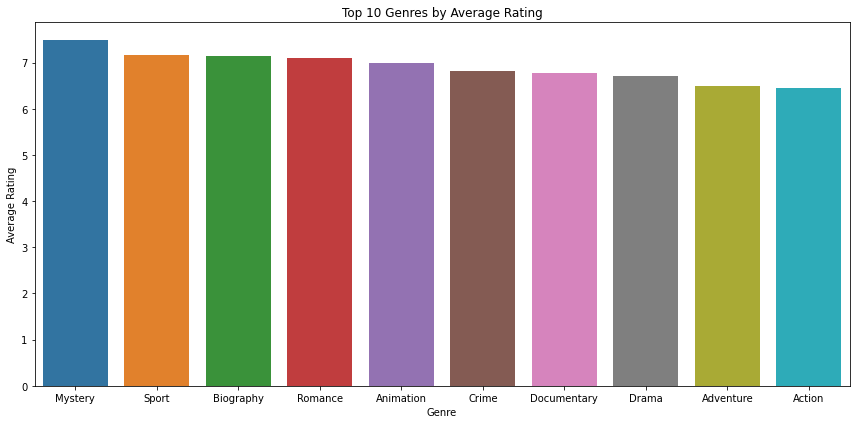

In [5535]:
# graph for genre v average_rating
barplot(top_10_genre_rating, 'genre1', 'average_rating', 'Top 10 Genres by Average Rating', 'Genre', 'Average Rating')

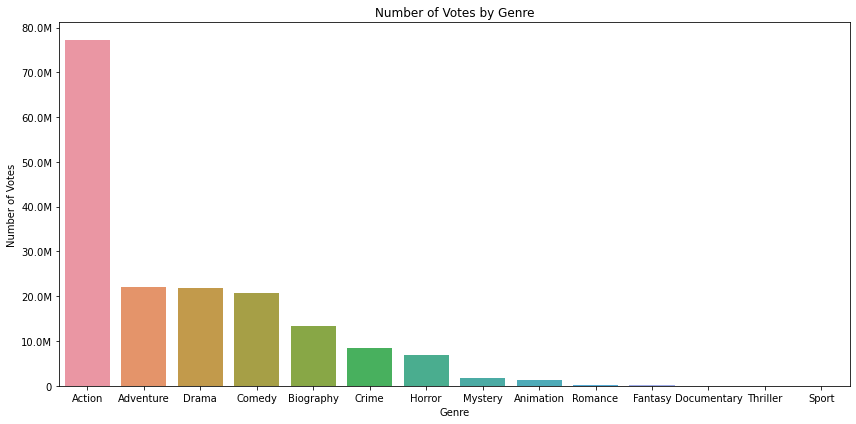

In [5536]:
# graph for number of votes by genre
barplot(genre_votes, 'genre1', 'num_votes', 'Number of Votes by Genre', 'Genre', 'Number of Votes')

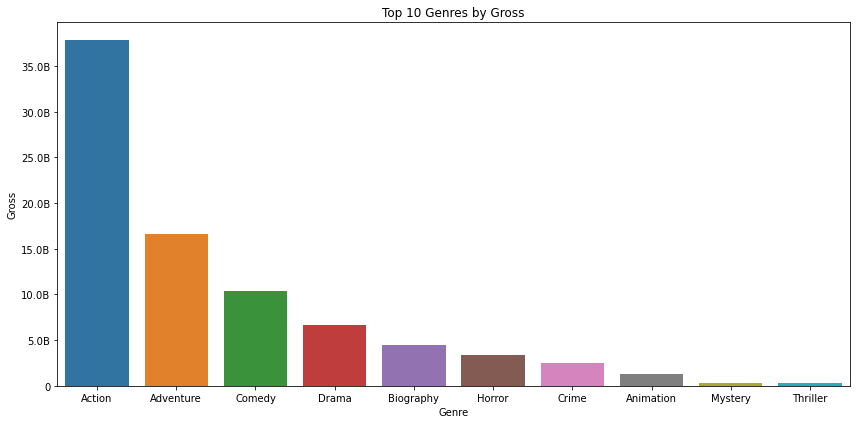

In [5537]:
# graph for genre v gross
barplot(top_10_genre_gross, 'genre1', 'domestic_gross', 'Top 10 Genres by Gross', 'Genre', 'Gross')

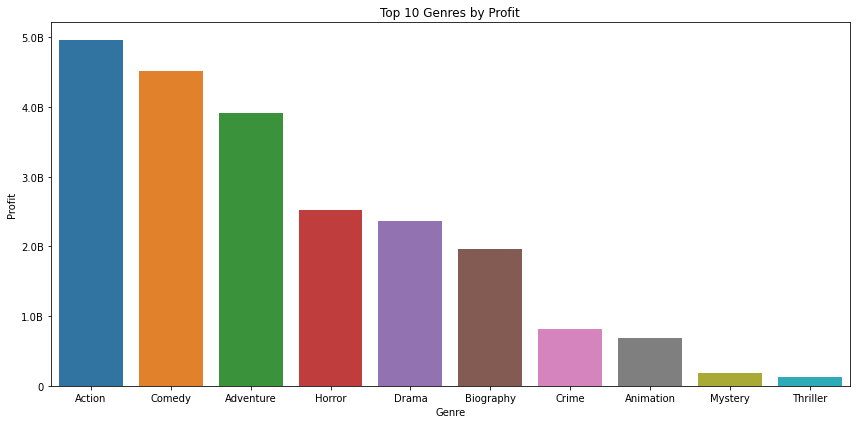

In [5538]:
# graph for genre v profit
barplot(top_10_genre_profit, 'genre1', 'profit_loss', 'Top 10 Genres by Profit', 'Genre', 'Profit')

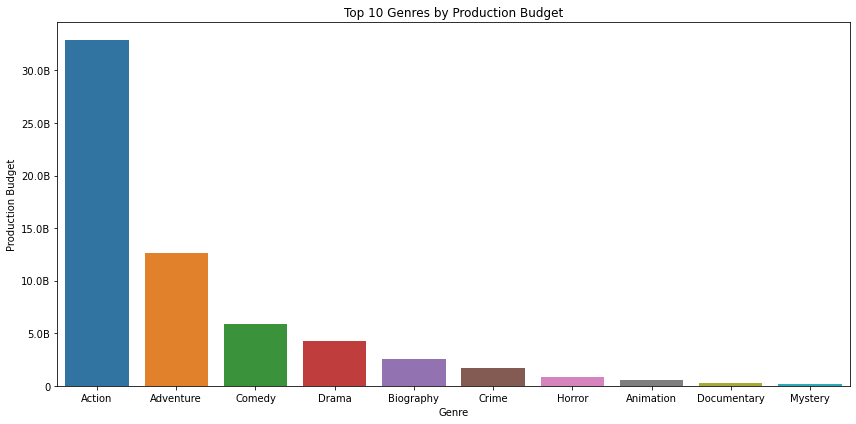

In [5539]:
# graph for genre v production_budget
barplot(top_10_genre_budget, 'genre1', 'production_budget', 'Top 10 Genres by Production Budget', 'Genre', 'Production Budget')

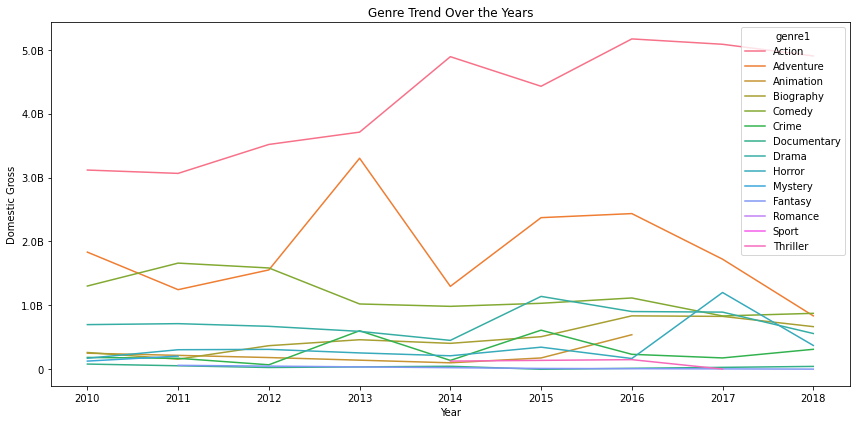

In [5540]:
# graph for year v genre
lineplot(genre_trend, 'year', 'domestic_gross', 'genre1', 'Genre Trend Over the Years', 'Year', 'Domestic Gross')

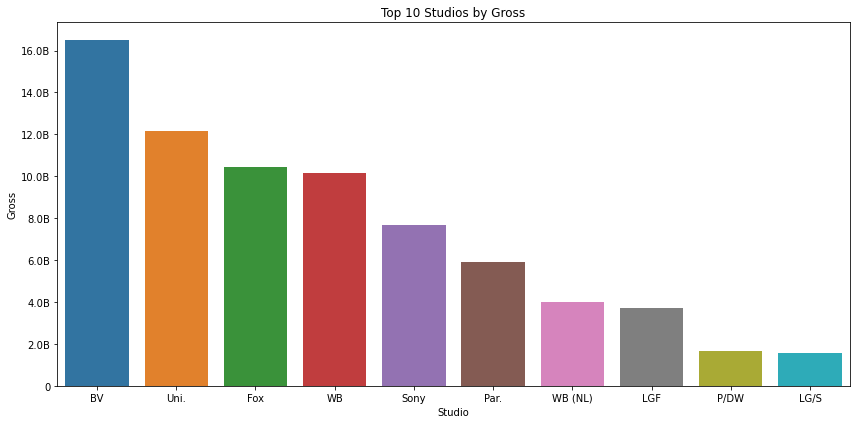

In [5541]:
# graph for studio v gross
barplot(top_10_studio_gross, 'studio', 'domestic_gross', 'Top 10 Studios by Gross', 'Studio', 'Gross')

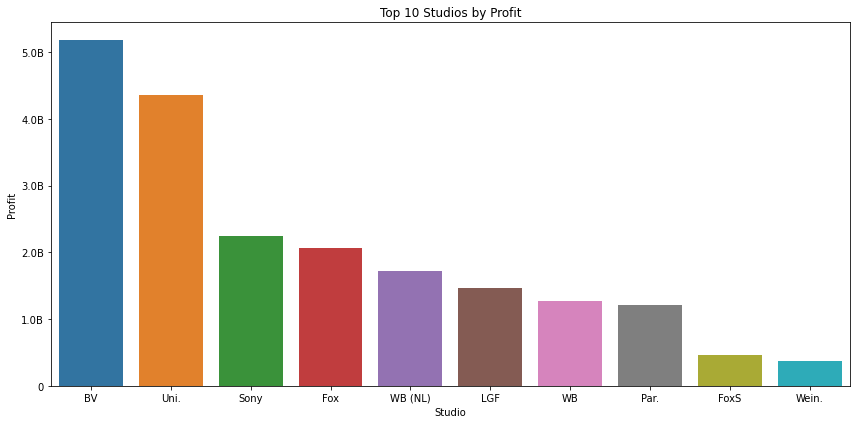

In [5542]:
# studio v profit
barplot(top_10_studio_profit, 'studio', 'profit_loss', 'Top 10 Studios by Profit', 'Studio', 'Profit')

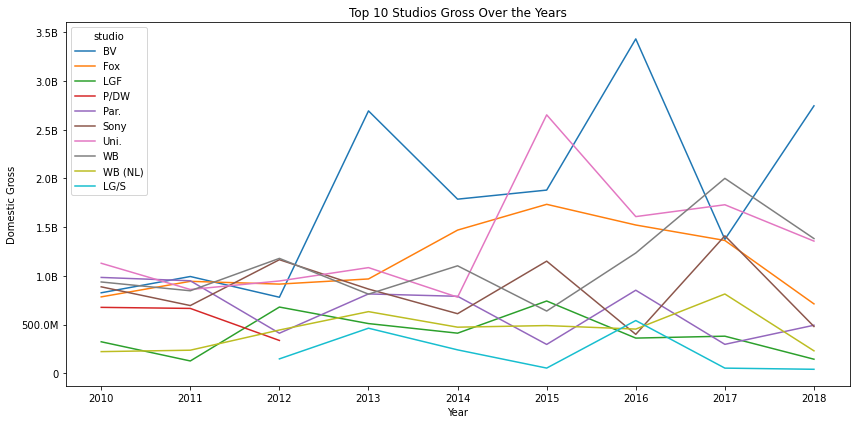

In [5543]:
# graph for year v studio v gross for top 10 studios
lineplot(top_10_year_studio_gross, 'year', 'domestic_gross', 'studio', 'Top 10 Studios Gross Over the Years', 'Year', 'Domestic Gross')

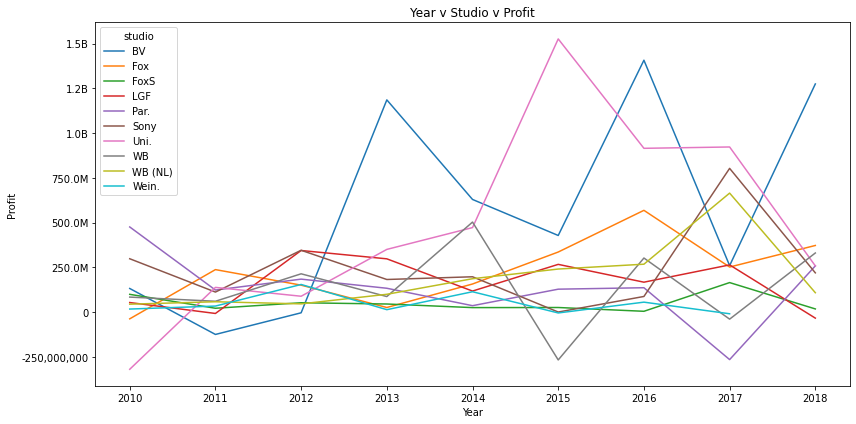

In [5544]:
# year v studio v profit for top 10 studios
lineplot(year_studio_profit[year_studio_profit['studio'].isin(top_10_year_studio_profit['studio'])], 'year', 'profit_loss', 'studio', 'Year v Studio v Profit', 'Year', 'Profit')

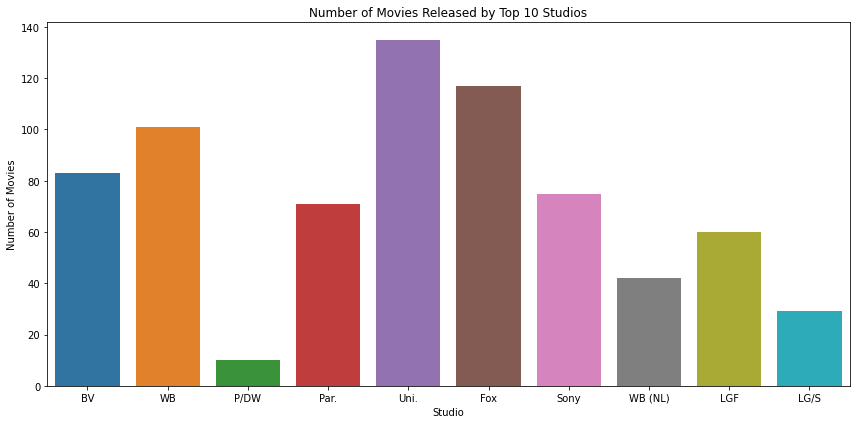

In [5545]:
# number of movies released by the top 10 studios
countplot(combined_movie_info[combined_movie_info['studio'].isin(top_10_studio_gross['studio'])], 'studio', 'Number of Movies Released by Top 10 Studios', 'Studio', 'Number of Movies')

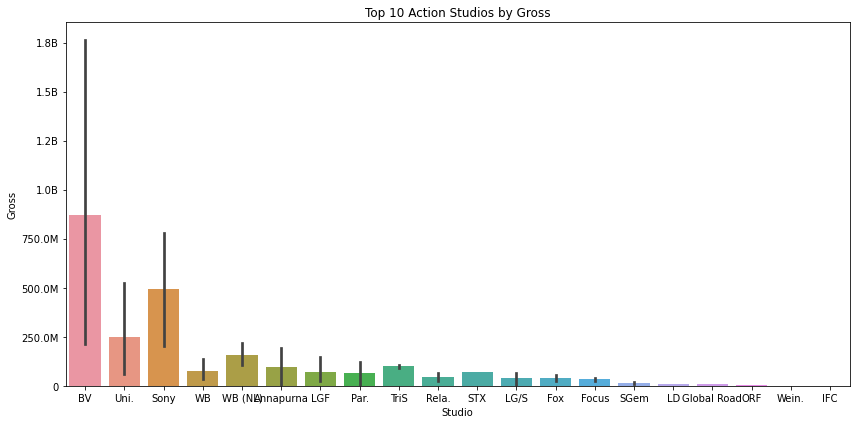

In [5546]:
# graph for studio in action genres
barplot(top_10_studio_genre_action, 'studio', 'domestic_gross', 'Top 10 Action Studios by Gross', 'Studio', 'Gross')

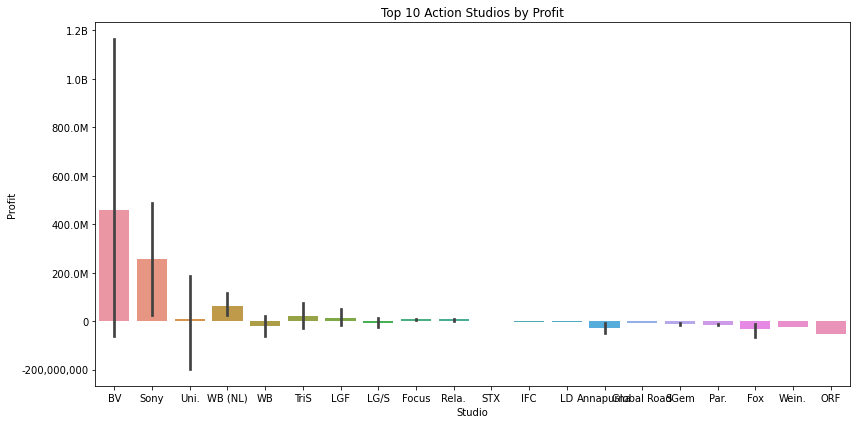

In [5547]:
# graph for studio in action genres for profit
barplot(top_10_studio_genre_action_profit, 'studio', 'profit_loss', 'Top 10 Action Studios by Profit', 'Studio', 'Profit')

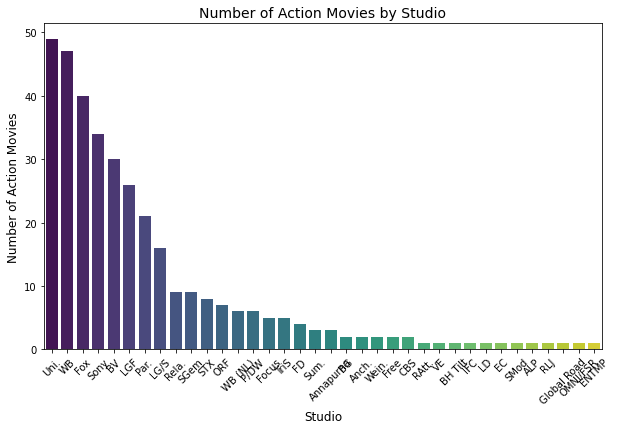

In [5548]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=studio_action_counts.index, y=studio_action_counts.values, palette='viridis')
ax.set_title('Number of Action Movies by Studio', fontsize=14, color='black')
ax.set_xlabel('Studio', fontsize=12, color='black')
ax.set_ylabel('Number of Action Movies', fontsize=12, color='black')
ax.tick_params(axis='x', colors='black', rotation=45)
ax.tick_params(axis='y', colors='black')
plt.savefig('images/Number of Action Movies by Studio.jpg')
plt.show()

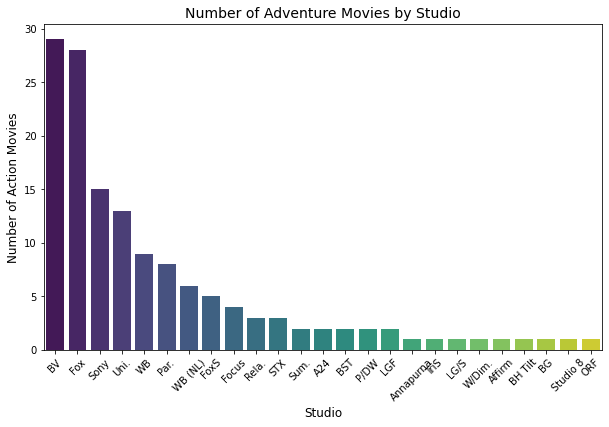

In [5549]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=studio_adventure_counts.index, y=studio_adventure_counts.values, palette='viridis')
ax.set_title('Number of Adventure Movies by Studio', fontsize=14, color='black')
ax.set_xlabel('Studio', fontsize=12, color='black')
ax.set_ylabel('Number of Action Movies', fontsize=12, color='black')
ax.tick_params(axis='x', colors='black', rotation=45)
ax.tick_params(axis='y', colors='black')
plt.savefig('images/Number of Adventure Movies by Studio.jpg')
plt.show()

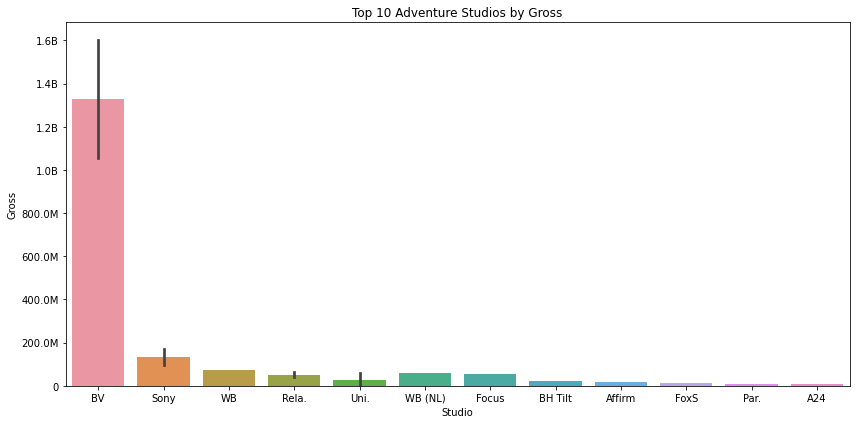

In [5550]:
# graph for studio in adventure genres
barplot(top_10_studio_genre_adventure, 'studio', 'domestic_gross', 'Top 10 Adventure Studios by Gross', 'Studio', 'Gross')

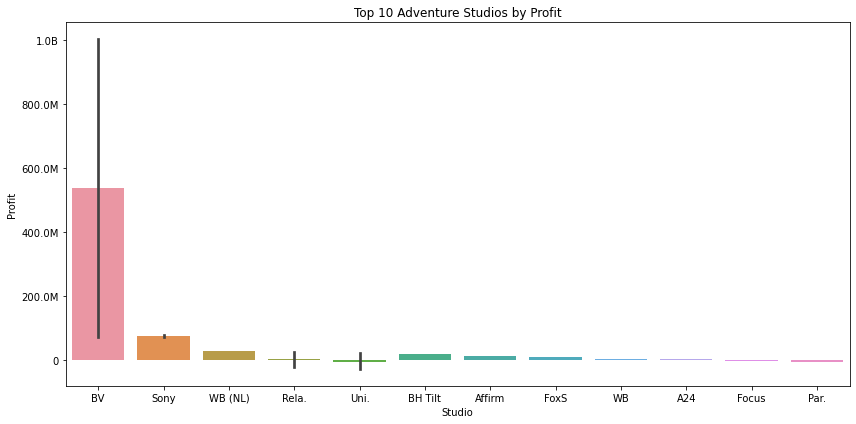

In [5551]:
# graph for studio in adventure genres for profit
barplot(top_10_studio_genre_adventure_profit, 'studio', 'profit_loss', 'Top 10 Adventure Studios by Profit', 'Studio', 'Profit')

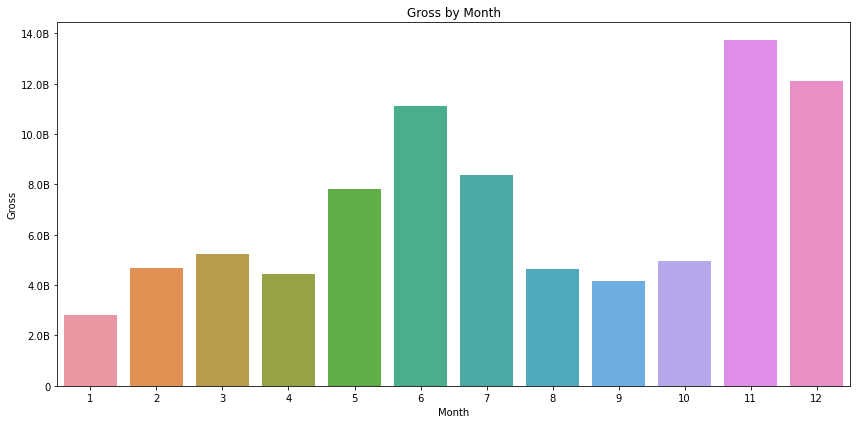

In [5552]:
# graph for month v gross
barplot(month_gross, 'month', 'domestic_gross', 'Gross by Month', 'Month', 'Gross')

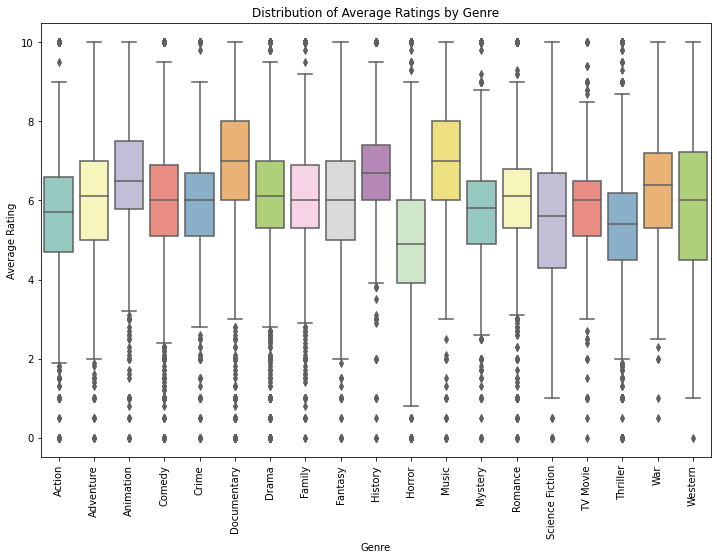

In [5553]:
# Distribution of Average Ratings by Genre
plt.figure(figsize=(12, 8))
sns.boxplot(x='genre', y='vote_average', data=genre_ratings, palette='Set3')
plt.title('Distribution of Average Ratings by Genre')
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.savefig('images/average_rating_by_genre.jpg')
plt.show()

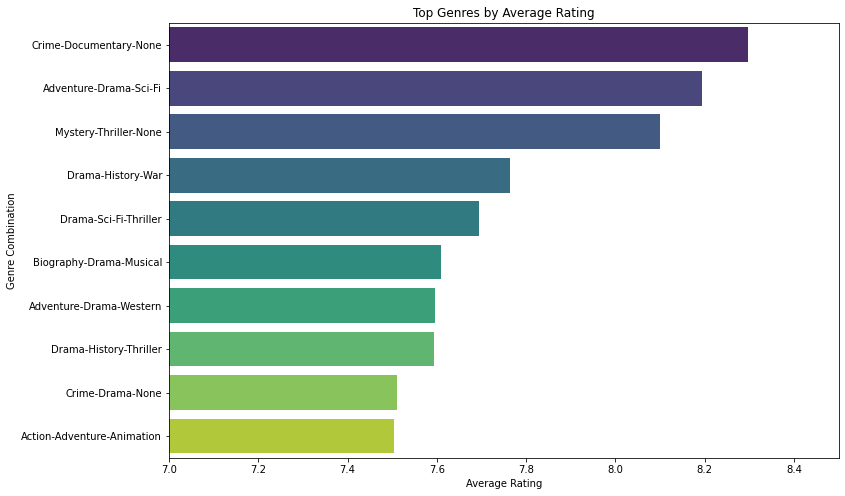

In [5554]:
# Bar plot for top genres by average rating
plt.figure(figsize=(12, 8))
sns.barplot(x='average_rating', y='genre_combination', data=top_genres_by_rating, palette='viridis')
plt.xlabel('Average Rating')
plt.ylabel('Genre Combination')
plt.title('Top Genres by Average Rating')
plt.xlim(7, 8.5)
plt.show()

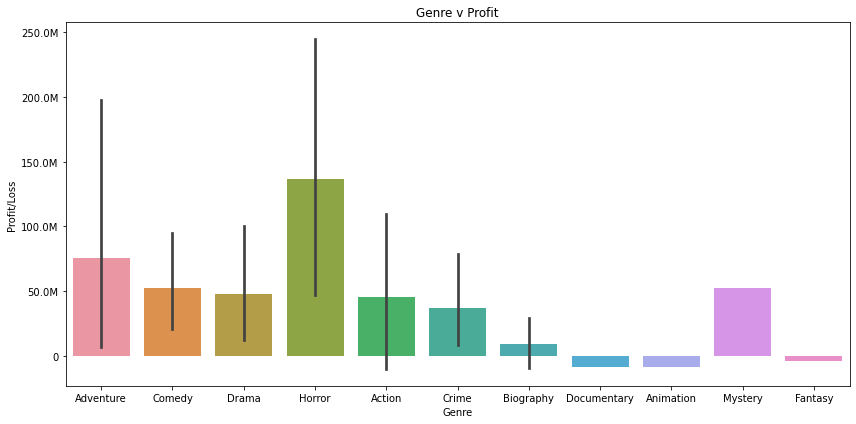

In [5555]:
# graph for profit and  genre
barplot(studio_genre_profit, 'genre1', 'profit_loss', 'Genre v Profit', 'Genre', 'Profit/Loss')

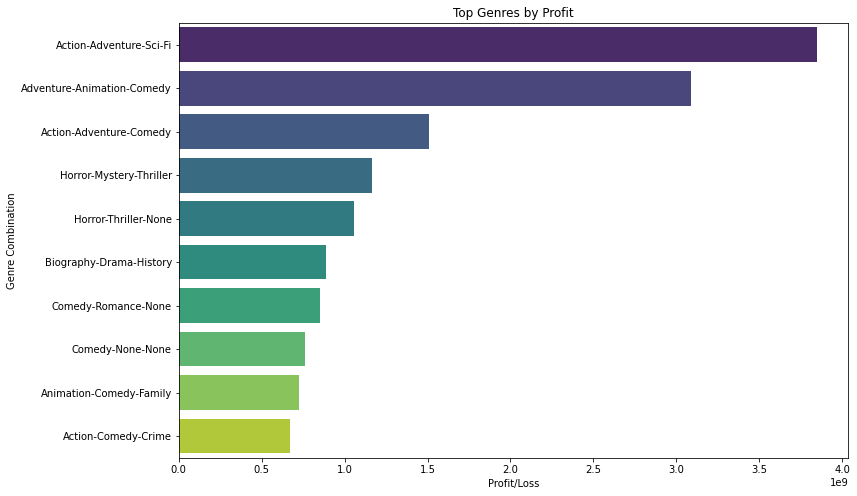

In [5556]:
# graph for top genres by profit
plt.figure(figsize=(12, 8))
sns.barplot(x='profit_loss', y='genre_combination', data=top_genres_by_profit, palette='viridis')
plt.xlabel('Profit/Loss')
plt.ylabel('Genre Combination')
plt.title('Top Genres by Profit')
plt.savefig('images/top_genres_by_profit.jpg')
plt.show()

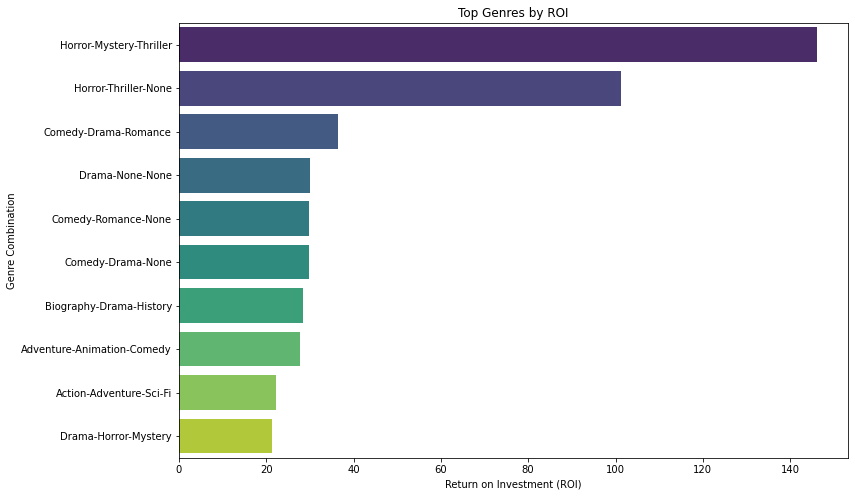

In [5557]:
# Bar plot for top genres by ROI
plt.figure(figsize=(12, 8))
sns.barplot(x='roi', y='genre_combination', data=top_genres_by_roi, palette='viridis')
plt.xlabel('Return on Investment (ROI)')
plt.ylabel('Genre Combination')
plt.title('Top Genres by ROI')
plt.show()

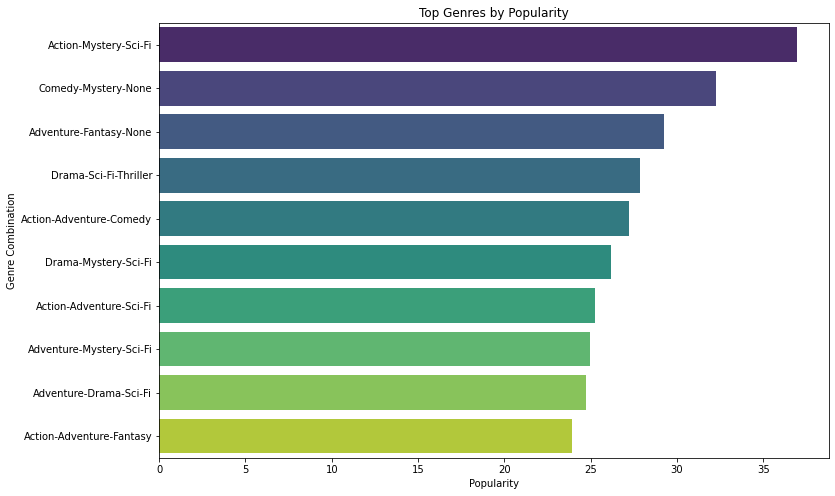

In [5558]:
# Bar plot for top genres by popularity
plt.figure(figsize=(12, 8))
sns.barplot(x='popularity', y='genre_combination', data=top_genres_by_popularity, palette='viridis')
plt.xlabel('Popularity')
plt.ylabel('Genre Combination')
plt.title('Top Genres by Popularity')
plt.savefig('images/top_genres_by_popularity.jpg')
plt.show()

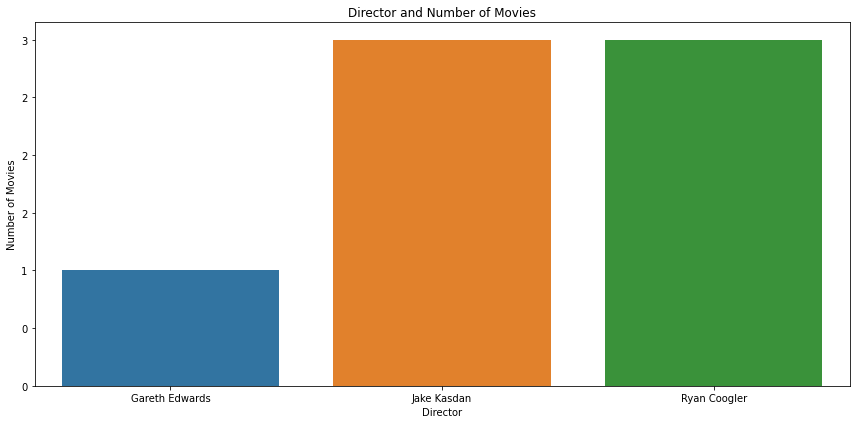

In [5571]:
# graph of director/producer and their total movies with the highest profit
countplot(best_other_movies, 'primary_name', 'Director and Number of Movies', 'Director', 'Number of Movies')

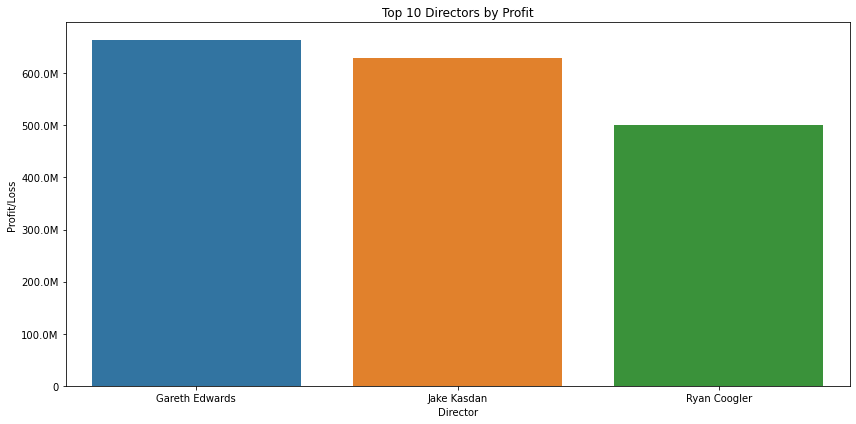

In [5570]:
# graph of total profits by director/producer using millions or billions function
barplot(best_director_producers, 'primary_name', 'profit_loss', 'Top 10 Directors by Profit', 'Director', 'Profit/Loss')

In [5561]:
best_other_movies

,title,studio,domestic_gross,average_rating,num_votes,production_budget,profit_loss,genre1,genre2,genre3,genre_combination,primary_name,birth_year,category
135,Rogue One: A Star Wars Story,BV,1.064355e+09,7.794284,975776,200000000.0,664354648.0,Action,Adventure,Sci-Fi,Action-Adventure-Sci-Fi,Gareth Edwards,1975.0,director
20,Bad Teacher,Sony,1.002929e+08,5.696856,184083,19000000.0,81292856.0,Comedy,Romance,None,Comedy-Romance-None,Jake Kasdan,1974.0,director
83,Jumanji: Welcome to the Jungle,Sony,8.090178e+08,6.991343,499896,90000000.0,629017832.0,Action,Adventure,Comedy,Action-Adventure-Comedy,Jake Kasdan,1974.0,director
144,Sex Tape,Sony,3.854347e+07,5.105201,103204,40000000.0,-1456527.0,Comedy,Romance,None,Comedy-Romance-None,Jake Kasdan,1974.0,director
25,Black Panther,BV,7.000596e+08,7.302340,528513,200000000.0,500059566.0,Action,Adventure,Sci-Fi,Action-Adventure-Sci-Fi,Ryan Coogler,1986.0,director
36,Creed,WB (NL),2.195352e+08,7.594739,457362,37000000.0,145535162.0,Drama,Sport,None,Drama-Sport-None,Ryan Coogler,1986.0,director
49,Fruitvale Station,Wein.,1.609900e+07,7.499063,68832,900000.0,15198998.0,Biography,Drama,Romance,Biography-Drama-Romance,Ryan Coogler,1986.0,director


In [5562]:
# Jake Kasdan other movies in all data
jake_kasdan_movies = successful_people[successful_people['primary_name'] == 'Jake Kasdan']
jake_kasdan_movies

,title,studio,domestic_gross,average_rating,num_votes,production_budget,profit_loss,genre1,genre2,genre3,genre_combination,primary_name,birth_year,category
20,Bad Teacher,Sony,100292856.0,5.696856,184083,19000000.0,81292856.0,Comedy,Romance,None,Comedy-Romance-None,Jake Kasdan,1974.0,director
83,Jumanji: Welcome to the Jungle,Sony,809017832.0,6.991343,499896,90000000.0,629017832.0,Action,Adventure,Comedy,Action-Adventure-Comedy,Jake Kasdan,1974.0,director
144,Sex Tape,Sony,38543473.0,5.105201,103204,40000000.0,-1456527.0,Comedy,Romance,None,Comedy-Romance-None,Jake Kasdan,1974.0,director


In [5563]:
# Jake Kasdan average rating
jake_kasdan_avg_rating = jake_kasdan_movies['average_rating'].mean()
jake_kasdan_avg_rating

5.931133238064848

In [5564]:
# Ryan Coogler other movies in all data
ryan_coogler_movies = successful_people[successful_people['primary_name'] == 'Ryan Coogler']
ryan_coogler_movies

,title,studio,domestic_gross,average_rating,num_votes,production_budget,profit_loss,genre1,genre2,genre3,genre_combination,primary_name,birth_year,category
25,Black Panther,BV,700059566.0,7.302340,528513,200000000.0,500059566.0,Action,Adventure,Sci-Fi,Action-Adventure-Sci-Fi,Ryan Coogler,1986.0,director
36,Creed,WB (NL),219535162.0,7.594739,457362,37000000.0,145535162.0,Drama,Sport,None,Drama-Sport-None,Ryan Coogler,1986.0,director
49,Fruitvale Station,Wein.,16098998.0,7.499063,68832,900000.0,15198998.0,Biography,Drama,Romance,Biography-Drama-Romance,Ryan Coogler,1986.0,director


In [5565]:
# Ryan Coogler's average rating
ryan_coogler = successful_people[successful_people['primary_name'] == 'Ryan Coogler']
ryan_coogler_avg_rating = ryan_coogler['average_rating'].mean()
ryan_coogler_avg_rating

7.4653806385295125

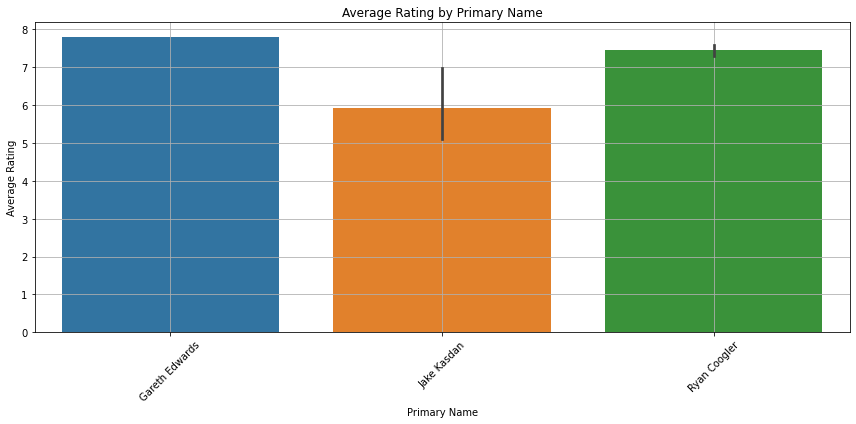

In [5566]:
# create a graph showing director and their movies with their ratings
plt.figure(figsize=(12, 6))
sns.barplot(data=best_other_movies, x='primary_name', y='average_rating')
plt.xlabel('Primary Name')
plt.ylabel('Average Rating')
plt.title('Average Rating by Primary Name')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('images/average_rating_by_primary_name.jpg')
plt.show()

## Documenting Findings

### 1. What genre of movies are really the "best"?

After taking a look at all of the data, it seems apparent that the genres of film that are the most successful are:
- Primary: Action
    - Action was the best in overall number of reviews, which means that the majority of the population enjoys watching action movies
    - Action movies are on average very expensive to make, but they have the highest profits out of all genres
    - Best in average domestic gross and profits
    - Action films have been growing for the past 8 years, ranking much higher than any other type of genre
- Secondary: Adventure
    - Adventure films are the second most popular type of genre
    - Second in average domestic gross
    - Third in average profits
- Tertiary: Comedy or Drama (or let the director choose)
    - We want the director/producer to develop a movie that they're most comfortable in
    - We don't want to force them to make a movie of any genre that they aren't comfortable in
    - But Comedy or Drama would be preferred but not required 
        - Comedy ranks second in average profits and third in domestic gross
        - Drama ranks fifth in average profits and fourth in domestic gross

These genres of films are the most consistent in all of our findings

### 2. Where and When should we start?

From our analysis we found that the best months for a movie to succeed are in the months of November and December

### 3. Who can help us?

- Studio: ***BV ~ Buena Vista***, but now known as ***Walt Disney Studios Motion Pictures***
- Director/Producer: ***Ryan Coogler***

BV has by far the best profits for making films with the genres of Action and Adventure. BV also has been steadily increasing in average profits with over 80 movies produced in 8 years

Ryan Coogler is the best option for us because he has a great profit ratio per movie, the highest average ratings between the 3 movies - Black Panther, Creed, Fruitvalue Station - of 7.47, and he has worked with BV in the past

### 4. Should we make sequels?

Short answer: ***Yes!***

- Most of the sequels are always profitable. They may not be growing exponentially or linearly, but they are always profitable!
- Movies with sequels have higher average gross of $114,977,887
- Creating sequels requires a well written story from even before anything - this will be up to Ryan to develop a story with the help of his team that he casts himself